In [ ]:
#pip install cairosvg
#import cairosvg

In [3]:
pip install lets-plot

In [4]:
pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 71.4 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
from scipy.stats import binom
from scipy.stats import poisson
import matplotlib.pyplot as plt
import pulp

# Modelle

## Deterministische Heuristik

In [6]:
def deterministic(C, beta_s):
    return int(C/beta_s)

## Statische Modelle

### 1. Statisches Single Fare Class Modell ohne Nachfrageunsicherheit

In [7]:
def static_single_1(C,theta,r,beta_s, max_limit):
    b = C +1
    threshold = r/theta
    while True:
        prob = 0
        for s in range(C,b):
            prob += binom.pmf(s,b,beta_s)
        if prob >= threshold:
            return b
        if b == max_limit:
            return b
        b = b + 1

### 2. Statisches Single Fare Class Modell mit Nachfrageunsicherheit

In [8]:
def expected_shows(b,C,demand):
    if b < C:
        return 0
    expected_value = 0
    for i in range(C,b+1):
        expected_value += (i-C) * poisson.pmf(i,mu=demand)
    return expected_value

def static_single_2(C, theta, r, demand, max_limit):
    b = C + 1
    while True:
        delta_r = r * (1-poisson.cdf(b, mu = demand)) - theta * (expected_shows(b+1, C, demand)-expected_shows(b, C, demand))
        if delta_r < 0:
            return b
        if b == max_limit:
            return b
        b = b + 1

### 3. Statisches Multiple Fare Class Modell mit totalem Buchungslimit

In [9]:
def calc_tau(r_list, alpha_list, beta_c_list, n_classes):
    tau = []
    for i in range(n_classes):
        tau.append(r_list[i] * (1 - alpha_list[i]*beta_c_list[i]))
    return tau

def calc_mu_0(p_list, tau, n_classes):
    mu_0 = 0
    for i in range(n_classes):
        mu_0 += p_list[i] * tau[i]
    return mu_0

def calc_beta_s(beta_s_list, p_list, n_classes):
    beta_s = 0
    for i in range(n_classes):
        beta_s += beta_s_list[i] * p_list[i]
    return beta_s

def static_multiple_1(C, r_list, beta_s_list, alpha_list, theta, beta_c_list, p_list, max_limit):
    ### Parameter
    n_classes = len(r_list)
    tau = calc_tau(r_list, alpha_list, beta_c_list, n_classes)
    beta_s = calc_beta_s(beta_s_list, p_list, n_classes)
    mu_0 = calc_mu_0(p_list, tau, n_classes)
    mu_1 = beta_s * theta
    gamma_b = beta_s**C
    ### Berechnung
    b = C
    while True:
        if gamma_b > mu_0/mu_1:
            return b
        gamma_next = gamma_b + beta_s * binom.pmf(C-1,b,beta_s)
        gamma_b = gamma_next
        if b == max_limit:
            return b
        b += 1





### 4. Einfaches Statisches Multiple Fare Class Modell mit verteilten Buchungslimits

In [10]:
def static_multiple_2(C, r_list, beta_s, theta, demand_list, max_limit):
    ### Parameter
    this_r_list = list(r_list)
    this_r_list.insert(0, 0)
    n_classes = len(this_r_list)
    this_demand_list = list(demand_list)
    this_demand_list.insert(0, 0)
    V = np.zeros((n_classes, max_limit))
    ### Berechnung von V[j,y]
    for y in range(max_limit):
        V[0, y] = -theta * max((y*beta_s - C),0)

    for j in range(1, n_classes):
        for y in range(max_limit):
            if y == 0:
                V[j, y] = 0
            else:
                max_value = -np.inf
                for u in range(this_demand_list[j]+1):
                    value = this_r_list[j] * u + V[j-1, min(y+u, max_limit-1)]
                    if value > max_value:
                        max_value = value
                V[j, y] = max_value
    ### Berechnung von b[j]
    b_opt = []
    for j in range(1, n_classes):
        for y in range(max_limit-1):
            value = this_r_list[j] + (V[j-1, y+1] - V[j-1, y])
            if value < 0:
                b_opt.append(y)
                break
            if y == max_limit-2:
                b_opt.append(max_limit)
                break
    return b_opt

### 5. Komplexes Statisches Multiple Fare Class Modell mit verteilten Buchungslimits

In [11]:
def static_multiple_3(C, r_list, alpha_list, beta_s_list, theta, demand_list, max_limit):
    ### Parameter
    n_classes = len(r_list)
    M = [int(max_limit*0.85), max_limit]
    #print(M)
    ### Berechnung
    prob = pulp.LpProblem("Optimization_Problem", pulp.LpMaximize)
    ## Entscheidungsvariablen
    x = [[pulp.LpVariable(f"x_{i}_{j}", cat='Binary') for j in range(M[i] + 1)] for i in range(n_classes)] # Binäre Variable
    w = pulp.LpVariable("w", lowBound=0, cat='Continuous') # Kontinuierliche Variable
    ## Zielfunktion
    objective = pulp.lpSum([r_list[i] * (1 - alpha_list[i] * beta_s_list[i]) * pulp.lpSum([min(demand_list[i],j) * x[i][j] for j in range(M[i] + 1)]) for i in range(n_classes)]) - theta * w
    prob += objective, "Objective"
    ## Nebenbedingungen
    prob += w >= pulp.lpSum([beta_s_list[i] * pulp.lpSum([min(demand_list[i],j) * x[i][j] for j in range(M[i] + 1)]) for i in range(n_classes)]) - C, "First_Constraint"
    for i in range(n_classes):
        prob += pulp.lpSum([x[i][j] for j in range(M[i] + 1)]) == 1, f"Binary_Choice_Constraint_{i}"
    ## Lösen des Problems
    prob.solve()
    b_opt = []
    for i in range(n_classes):
        for j in range(M[i] + 1):
            if x[i][j].varValue == 1:
                b_opt.append(j)
                break
    return b_opt

## Dynamische Modelle

### 1. Dynamisches Single Fare Class Modell

In [12]:
def dynamic_single(C, r, beta_c, theta, lambda_d, kappa, K, max_limit):
      ### Parameter
      T = K+1
      V = np.zeros((T, max_limit))
      demand_list = []
      for i in range(T):
          demand_list.append(lambda_d)
      ### Berechnung
      def calc_v(t, x):
          #print(x)
          value = V[t, int(x * (1 - beta_c))] - (x - int(x * (1-beta_c))) * kappa
          return value

      for y in range(max_limit):
          V[T-1,y] = -theta * max(y - C, 0)

      for t in range(T-2, -1, -1):
          for y in range(max_limit-1):
              max_value = -np.inf
              for x in range(y, min(int(y + demand_list[t]), max_limit-1)):
                  value = calc_v(t+1, x) + (x - y) * r
                  if value > max_value:
                      max_value = value
              V[t,y] = max_value

      b_opt = []
      for t in range(T-2, -1, -1):
          for y in range(max_limit):
              delta_V = V[t+1, y] - V[t+1, y+1]
              if r < delta_V:
                  b_opt.append(y)
                  break
              if y == max_limit-3:
                  b_opt.append(max_limit)
                  break
      b_opt.reverse()
      return b_opt

#def dynamic_single():
#    return 0

### 2. Dynamisches Multiple Fare Class Modell

In [13]:
def dynamic_multiple(C, r_list, beta_s, p_0, f_list, theta, kappa, K, max_limit, lambda_c, h):
    K = K+1
    beta_c = 1 - np.exp(-lambda_c*h)
    def calc_p(i):
        if i==0:
            return p_0
        else:
            return f_list[i] * (1 - p_0)

    def calc_gamma(k, n, i):
        if i==0:
            return J[k,n]
        else:
            return max(r_list[i] + J[k, n+1], J[k, n])
    ### Parameter
    J = np.zeros((K, max_limit))
    n_classes = len(r_list)

    ### Berechnung von J[k,n]
    for n in range(max_limit):
        J[K-1, n] = -kappa * n * beta_c - theta * max(n * (beta_s * (1 - beta_c)) - C, 0)

    for k in range(K-2, -1, -1):
        for n in range(max_limit):
            value = -kappa * n * beta_c
            for i in range(n_classes):
                value += calc_p(i) * calc_gamma(k+1, int(n * (1 - beta_c)), i)
            J[k, n] = value

    ### Berechnung von b_opt
    b_opts = []
    for k in range(0, K-1):
        b_opt = []
        for i in range(1, n_classes):
            for n in range(max_limit):
                opt_value = J[k+1, n] - J[k+1, n+1]
                if r_list[i] < opt_value:
                   #print(i)
                   #b_opt[k,i] = {"Tarifklasse" : i, "Buchungslimit" : n}
                   if n < 100:
                      b_opt.append(max_limit)
                   else:
                      b_opt.append(n)
                   #b_opt[k, i-1] = n
                   break
                if n == max_limit-2:
                   #b_opt[k, i-1] = max_limit
                   #b_opt[k,i] = {"Tarifklasse" : i, "Buchungslimit" : max_limit}
                   b_opt.append(max_limit)
                   break
        b_opts.append(b_opt)


    return b_opts



# Simulation Single Fare Class

## Modellparameter

### Parameter

In [14]:
C = 200
max_limit = 300
theta = 400
### Static
r = 140
beta_s = 0.95
beta_c = 0.05
demand = 240
### Dynamic
lambda_d = 2.4
K = 100
kappa = 140

### Optimale Buchungslimits

In [15]:
b_dh = deterministic(C, beta_s)
b_ss1 = static_single_1(C, theta, r, beta_s, max_limit)
b_ss2 = static_single_2(C, theta, r, demand, max_limit)
b_ds = dynamic_single(C, r, beta_c, theta, lambda_d, kappa, K, max_limit)
single_b_opt = {"DH" : b_dh, "SS1" : b_ss1, "SS2" : b_ss2, "DS" : b_ds}
print(single_b_opt)

{'DH': 210, 'SS1': 209, 'SS2': 222, 'DS': [300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 291, 276, 262, 248, 235, 223, 211, 200]}


## Simulationsparameter

In [16]:
T = 100
K = 100
h = T/K
results = {}

refunds = [1]
revenues = [140]
theta = 400
results_storage = {}
total_arrivals_cancellations = {}

## Ausführung

In [17]:
arrival_mean = 2.4
cancellation_mean = [0.05]
show_mean = [0.95]
show_variances = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
arrival_variances = [0.0, 0.5, 1, 1.5, 2, 2.5, 3]
cancellation_variances = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
#fare_class_probs = [0.9, 0.1]
results_storage = {}
total_arrivals_cancellations = {}
mylist = []


def calc_fare_class_probs(p_0):
    return 1 - p_0, p_0

samples = 20
for show_variance in show_variances:
    for arrival_variance in arrival_variances:
      for cancellation_variance in cancellation_variances:
            results_over_samples = {}
            arrivals_cancellations = {}
            for sample in range(1,samples+1):
                random_seed = sample
                np.random.seed(random_seed)
                results = {}
                arrivals_per_k = np.zeros((K))
                cancellations_per_k = np.zeros((K))
                arrivals_cancellations[sample] = {"Arrivals" : arrivals_per_k, "Cancellations" : cancellations_per_k}
                arrival_rate = max(np.random.normal(arrival_mean, arrival_variance),0)
                p_0 = np.exp(-arrival_mean*h)
                cancellation_rate = [max(np.random.normal(mean, cancellation_variance), 0) for mean in cancellation_mean]
                show_probs = [min(np.random.normal(mean, show_variance), 1) for mean in show_mean]
                for b_opt in single_b_opt.keys():
                    np.random.seed(random_seed)
                    reservations = 0
                    reservations_per_class = np.zeros(len(show_mean))
                    cancellations_per_class = np.zeros(len(show_mean))
                    arrivals_per_class = np.zeros(len(show_mean))
                    revenue = 0
                    for k in range(K):
                        arrivals = np.random.poisson(arrival_rate)
                        arrivals_per_k[k] = arrivals
                        if b_opt == "DS":
                            for _ in range(arrivals):
                                fare_class_probs = list(calc_fare_class_probs(p_0))
                                fare_class = np.random.choice(len(fare_class_probs), p=fare_class_probs)
                                if not fare_class == 1:
                                  arrivals_per_class[fare_class] += 1
                                  if np.sum(reservations_per_class) < single_b_opt[b_opt][k]:
                                      reservations += 1
                                      reservations_per_class[fare_class] += 1
                                      revenue += revenues[fare_class]
                            for i in range(len(revenues)):
                                cancellations = np.random.poisson(cancellation_rate[i])
                                cancellations_per_k[k] += cancellations
                                reservations_per_class[i] -= cancellations
                                revenue -= cancellations * revenues[i] * refunds[i]
                                cancellations_per_class[i] += cancellations
                        else:
                            for _ in range(arrivals):
                                fare_class_probs = list(calc_fare_class_probs(p_0))
                                fare_class = np.random.choice(len(fare_class_probs), p=fare_class_probs)
                                if not fare_class == 1:
                                  arrivals_per_class[fare_class] += 1
                                  if np.sum(reservations_per_class) < single_b_opt[b_opt]:
                                      reservations += 1
                                      reservations_per_class[fare_class] += 1
                                      revenue += revenues[fare_class]
                            for i in range(len(revenues)):
                                cancellations = np.random.poisson(cancellation_rate[i])
                                cancellations_per_k[k] += cancellations
                                reservations_per_class[i] -= cancellations
                                revenue -= cancellations * revenues[i] * refunds[i]
                                cancellations_per_class[i] += cancellations


                    shows_per_class = np.zeros(len(fare_class_probs))
                    for i in range(len(revenues)):
                        shows_per_class[i] += np.random.binomial(max(reservations_per_class[i],0),show_probs[i])

                    total_revenue = 0
                    revenue_loss = 0
                    for i in range(len(revenues)):
                        total_revenue += shows_per_class[i] * revenues[i]
                        #total_revenue += reservations_per_class[i] * revenues[i]
                    total_revenue -= theta * max(np.sum(shows_per_class)-C, 0)
                    revenue_loss = max(C - np.sum(shows_per_class),0) * (np.sum(revenues)/len(revenues))
                    #revenue_loss = max(C - np.sum(reservations_per_class),0) * np.sum(revenues)/len(revenues)
                    unused_inventory = (max(C - np.sum(shows_per_class),0)/C)
                    results[b_opt] = {"b_opt": single_b_opt[b_opt], "Arrivals per Class" : arrivals_per_class, "Cancellations per Class" : cancellations_per_class, "Total Revenue" : total_revenue, "Expected Revenue Loss" : revenue_loss, "Unused Inventory" : unused_inventory, "Accepted Reservations per Class" : reservations_per_class, "Shows at Departure" : np.sum(shows_per_class), "Denied boardings" : max(np.sum(shows_per_class)-C,0), "Denied boarding Costs" : max(np.sum(shows_per_class)-C,0) * theta}
                results_over_samples[sample] = results
            results_storage[(show_variance, arrival_variance, cancellation_variance, tuple(fare_class_probs))] = results_over_samples
            total_arrivals_cancellations[(show_variance, arrival_variance, cancellation_variance, tuple(fare_class_probs))] = arrivals_cancellations

#for results in results_storage:
#    print(f"{results}: {results_storage[results]}")

## Als Dataframe umwandeln

In [18]:
import pandas as pd

# Initialize an empty list to hold all rows of data
data_rows = []
# Iterate over the results_storage dictionary to extract and flatten the data
for param_key, results_by_b_opt in results_storage.items():
    # Unpack the parameter key (which is a tuple of arrival_rate, cancellation_rate, and fare_class_probs)
    show_variance, arrival_variance, cancellation_variance, fare_class_probs = param_key

    # Iterate over each b_opt and its corresponding results
    for sample, results_by_model in results_by_b_opt.items():
        for model, result_metrics in results_by_model.items(): # Access the innermost dictionary
            # Create a dictionary for this row of data
            row_data = {
                'show_variance': show_variance,
                'arrival_variance': arrival_variance,
                'cancellation_variance': cancellation_variance,
                'fare_class_probs_1': fare_class_probs[0],
                'fare_class_probs_2': fare_class_probs[1],
                #'show_rate_1': show_probs_list[0],
                #'show_rate_2': show_probs_list[1],
                'sample': sample,
                'Modell': model, # Include the model information
                'Total Revenue': result_metrics['Total Revenue'],
                'Unused Inventory': result_metrics['Unused Inventory'],
                'Expected Revenue Loss': result_metrics['Expected Revenue Loss'],
                'Shows at Departure': result_metrics['Shows at Departure'],
                'Denied boardings': result_metrics['Denied boardings'],
                'Denied boarding Costs': result_metrics['Denied boarding Costs'],
            }

            # Add per-class metrics to the row (assuming 2 fare classes here)

            row_data['b_opt for all Classes'] = result_metrics['b_opt']
            row_data['Arrivals per Class 1'] = result_metrics['Arrivals per Class'][0]
            row_data['Cancellations per Class 1'] = result_metrics['Cancellations per Class'][0]
            row_data['Accepted Reservations per Class 1'] = result_metrics['Accepted Reservations per Class'][0]

            # Append the row data to the list
            data_rows.append(row_data)

# Convert the list of dictionaries into a pandas DataFrame
df_results_storage = pd.DataFrame(data_rows)
df_results_storage['b_opt for all Classes'] = df_results_storage['b_opt for all Classes'].apply(lambda x: sum(x)/len(x) if isinstance(x, list) else x)
df_results_storage.head(10)
#df_results_storage[df_results_storage['show_variance']==0]# and df_results_storage['variance']==0]
#df_results_storage.groupby(['arrival_rate', 'cancellation_rate_1', 'cancellation_rate_2', 'fare_class_probs_1', 'fare_class_probs_2', 'model']).mean()
#df_results_storage.sort_values(['arrival_rate', 'cancellation_rate_1', 'cancellation_rate_2', 'fare_class_probs_1', 'fare_class_probs_2', 'model'])

,show_variance,arrival_variance,cancellation_variance,fare_class_probs_1,fare_class_probs_2,sample,Modell,Total Revenue,Unused Inventory,Expected Revenue Loss,Shows at Departure,Denied boardings,Denied boarding Costs,b_opt for all Classes,Arrivals per Class 1,Cancellations per Class 1,Accepted Reservations per Class 1
0,0.0,0.0,0.0,0.909282,0.090718,1,DH,27860.0,0.005,140.0,199.0,0.0,0.0,210.00,224.0,6.0,210.0
1,0.0,0.0,0.0,0.909282,0.090718,1,SS1,27720.0,0.010,280.0,198.0,0.0,0.0,209.00,224.0,6.0,209.0
2,0.0,0.0,0.0,0.909282,0.090718,1,SS2,26180.0,0.000,0.0,207.0,7.0,2800.0,222.00,224.0,6.0,218.0
3,0.0,0.0,0.0,0.909282,0.090718,1,DS,27740.0,0.000,0.0,201.0,1.0,400.0,295.46,224.0,6.0,212.0
4,0.0,0.0,0.0,0.909282,0.090718,2,DH,26880.0,0.040,1120.0,192.0,0.0,0.0,210.00,206.0,6.0,200.0
5,0.0,0.0,0.0,0.909282,0.090718,2,SS1,26880.0,0.040,1120.0,192.0,0.0,0.0,209.00,206.0,6.0,200.0
6,0.0,0.0,0.0,0.909282,0.090718,2,SS2,26880.0,0.040,1120.0,192.0,0.0,0.0,222.00,206.0,6.0,200.0
7,0.0,0.0,0.0,0.909282,0.090718,2,DS,26880.0,0.040,1120.0,192.0,0.0,0.0,295.46,206.0,6.0,200.0
8,0.0,0.0,0.0,0.909282,0.090718,3,DH,27220.0,0.000,0.0,203.0,3.0,1200.0,210.00,215.0,4.0,210.0
9,0.0,0.0,0.0,0.909282,0.090718,3,SS1,27480.0,0.000,0.0,202.0,2.0,800.0,209.00,215.0,4.0,209.0


## Visualisierung

### Show Rate

#### Total Revenue

##### Matplot

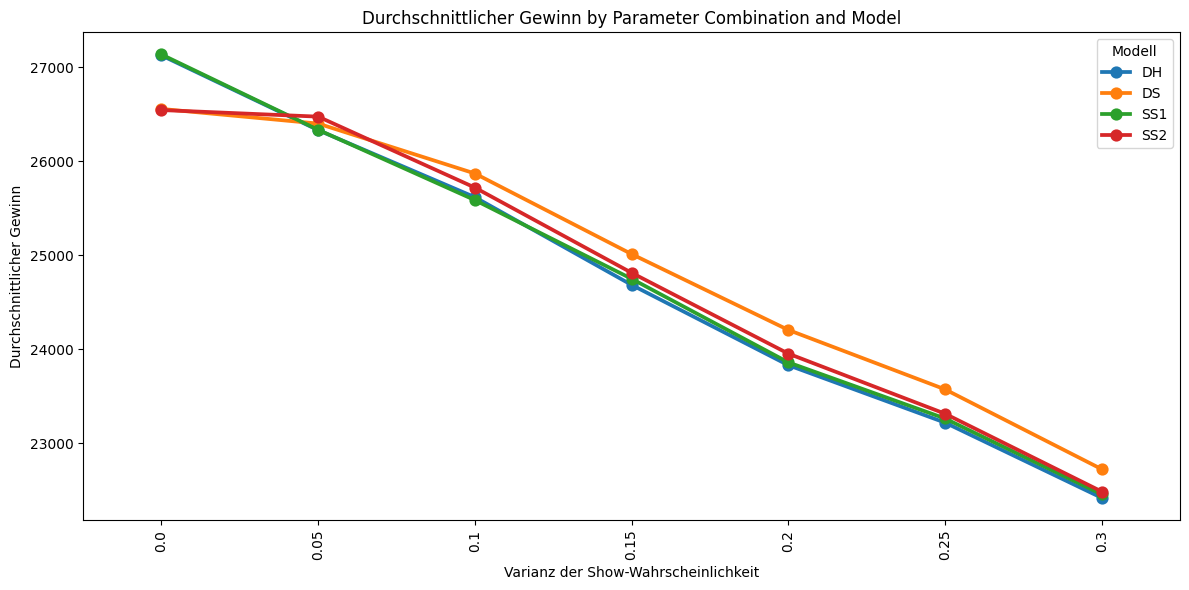

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size for better readability
plt.figure(figsize=(12, 6))
df_results_storage_show_rate = df_results_storage[(df_results_storage['arrival_variance']==0) & (df_results_storage['cancellation_variance'] == 0)].groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell', 'b_opt for all Classes']).mean()
# Create the boxplot
sns.pointplot(x='show_variance', y='Total Revenue', hue='Modell',data=df_results_storage_show_rate)

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)

# Set plot title and labels
plt.title('Durchschnittlicher Gewinn by Parameter Combination and Model')
plt.xlabel('Varianz der Show-Wahrscheinlichkeit')
plt.ylabel('Durchschnittlicher Gewinn')
plt.legend(title='Modell')

# Show the plot
plt.tight_layout()
plt.show()

##### Lets Plot

In [20]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell', 'b_opt for all Classes']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))

# Display the plot
p

In [21]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell', 'b_opt for all Classes']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
p

#### Denied Boardings

##### Matplot

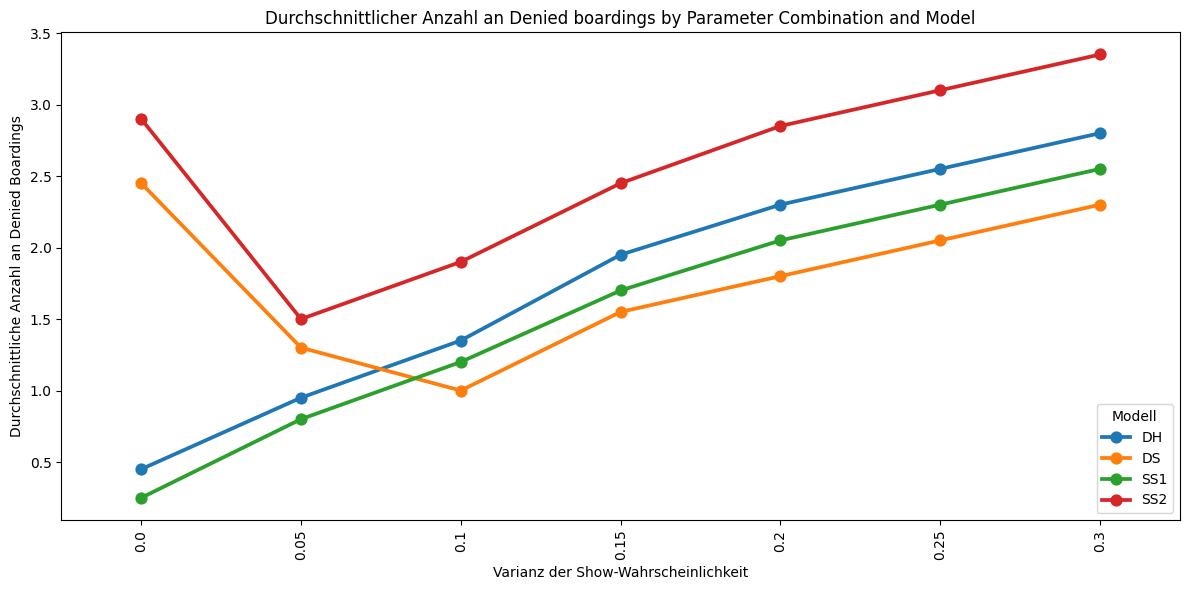

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

df_results_storage_show_rate = df_results_storage[(df_results_storage['arrival_variance']==0) & (df_results_storage['cancellation_variance'] == 0)].groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean()
# Create the boxplot
sns.pointplot(x='show_variance', y='Denied boardings', hue='Modell',data=df_results_storage_show_rate)

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)
#plt.ylim(4000, 32500)

# Set plot title and labels
plt.title('Durchschnittlicher Anzahl an Denied boardings by Parameter Combination and Model')
plt.xlabel('Varianz der Show-Wahrscheinlichkeit')
plt.ylabel('Durchschnittliche Anzahl an Denied Boardings')
plt.legend(title='Modell')

# Show the plot
plt.tight_layout()
plt.show()

##### Lets Plot

In [23]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell', 'b_opt for all Classes']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
p

In [24]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell', 'b_opt for all Classes']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
ggsave(p, filename='s_show_db_box.pdf')
# Display the plot
p


To export Lets-Plot figure to a PNG or PDF file please install CairoSVG libraryto your Python environment.
CairoSVG is free and distributed under the LGPL-3.0 license.
For more details visit: https://cairosvg.org/documentation/



#### Unused Inventory

##### Matplot

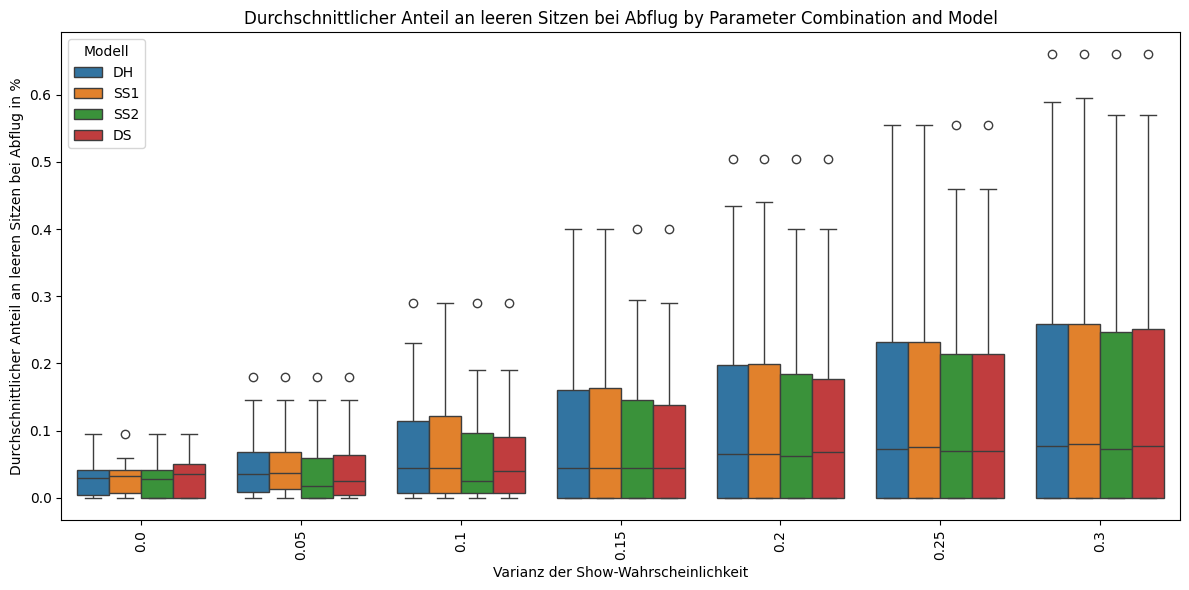

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

df_results_storage_show_rate = df_results_storage[(df_results_storage['arrival_variance']==0) & (df_results_storage['cancellation_variance'] == 0)]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'model']).mean()
# Create the boxplot
sns.boxplot(x='show_variance', y='Unused Inventory', hue='Modell',data=df_results_storage_show_rate)

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)
#plt.ylim(4000, 32500)

# Set plot title and labels
plt.title('Durchschnittlicher Anteil an leeren Sitzen bei Abflug by Parameter Combination and Model')
plt.xlabel('Varianz der Show-Wahrscheinlichkeit')
plt.ylabel('Durchschnittlicher Anteil an leeren Sitzen bei Abflug in %')
plt.legend(title='Modell')

# Show the plot
plt.tight_layout()
plt.show()

##### Lets Plot

In [26]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell', 'b_opt for all Classes']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
p

In [27]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell', 'b_opt for all Classes']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
p

### Arrival Rate

#### Total Revenue

##### Matplot

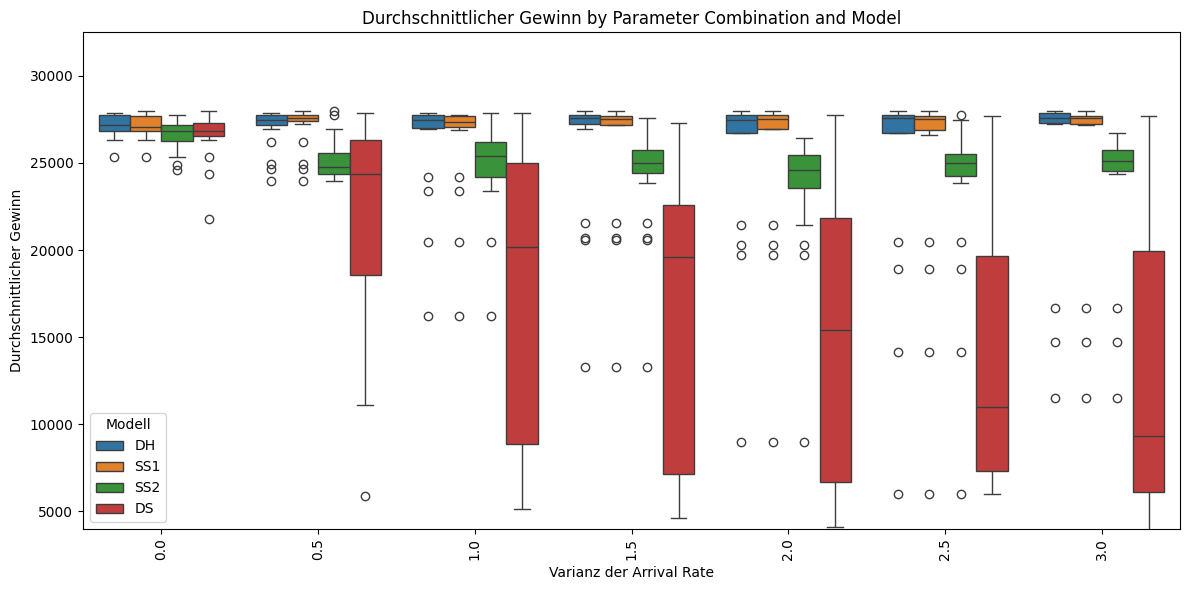

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

df_results_storage_show_rate = df_results_storage[(df_results_storage['show_variance']==0) & (df_results_storage['cancellation_variance'] == 0)]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'model']).mean()
# Create the boxplot
sns.boxplot(x='arrival_variance', y='Total Revenue', hue='Modell',data=df_results_storage_show_rate)

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)
plt.ylim(4000, 32500)

# Set plot title and labels
plt.title('Durchschnittlicher Gewinn by Parameter Combination and Model')
plt.xlabel('Varianz der Arrival Rate')
plt.ylabel('Durchschnittlicher Gewinn')
plt.legend(title='Modell')

# Show the plot
plt.tight_layout()
plt.show()

##### Lets Plot

In [29]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell', 'b_opt for all Classes']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))

# Display the plot
p

In [30]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell', 'b_opt for all Classes']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))

# Display the plot
p

#### Denied Boardings

##### Matplot

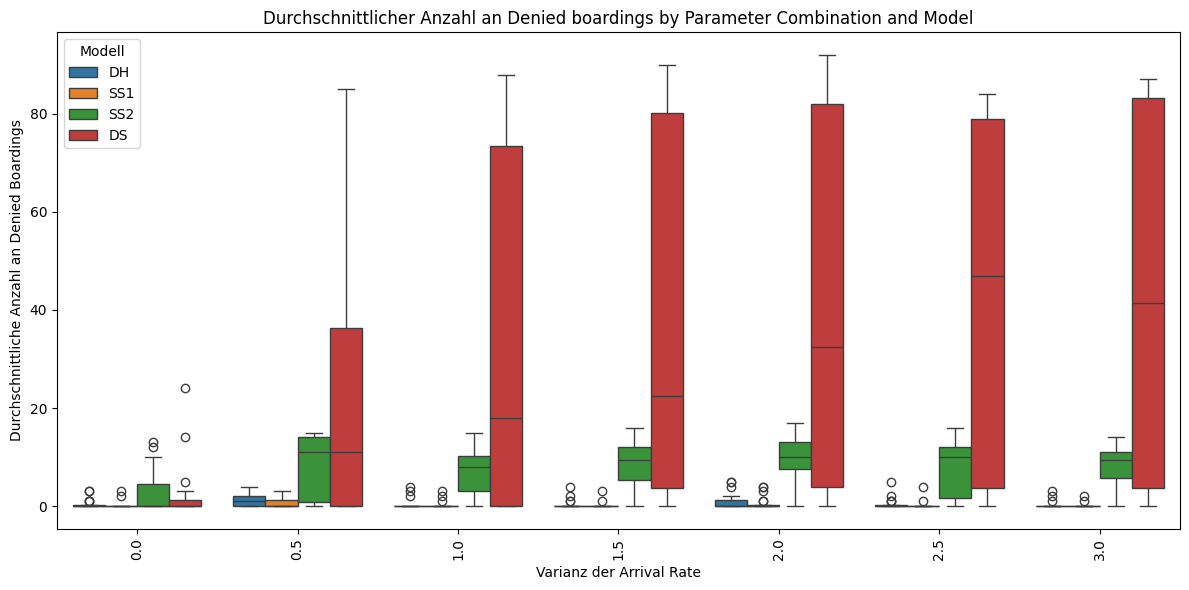

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

df_results_storage_show_rate = df_results_storage[(df_results_storage['show_variance']==0) & (df_results_storage['cancellation_variance'] == 0)]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'model']).mean()
# Create the boxplot
sns.boxplot(x='arrival_variance', y='Denied boardings', hue='Modell',data=df_results_storage_show_rate)

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)
#plt.ylim(4000, 32500)

# Set plot title and labels
plt.title('Durchschnittlicher Anzahl an Denied boardings by Parameter Combination and Model')
plt.xlabel('Varianz der Arrival Rate')
plt.ylabel('Durchschnittliche Anzahl an Denied Boardings')
plt.legend(title='Modell')

# Show the plot
plt.tight_layout()
plt.show()

##### Lets Plot

In [32]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell', 'b_opt for all Classes']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))

# Display the plot
p

In [33]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell', 'b_opt for all Classes']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
p

#### Unused Inventory

##### Matplot

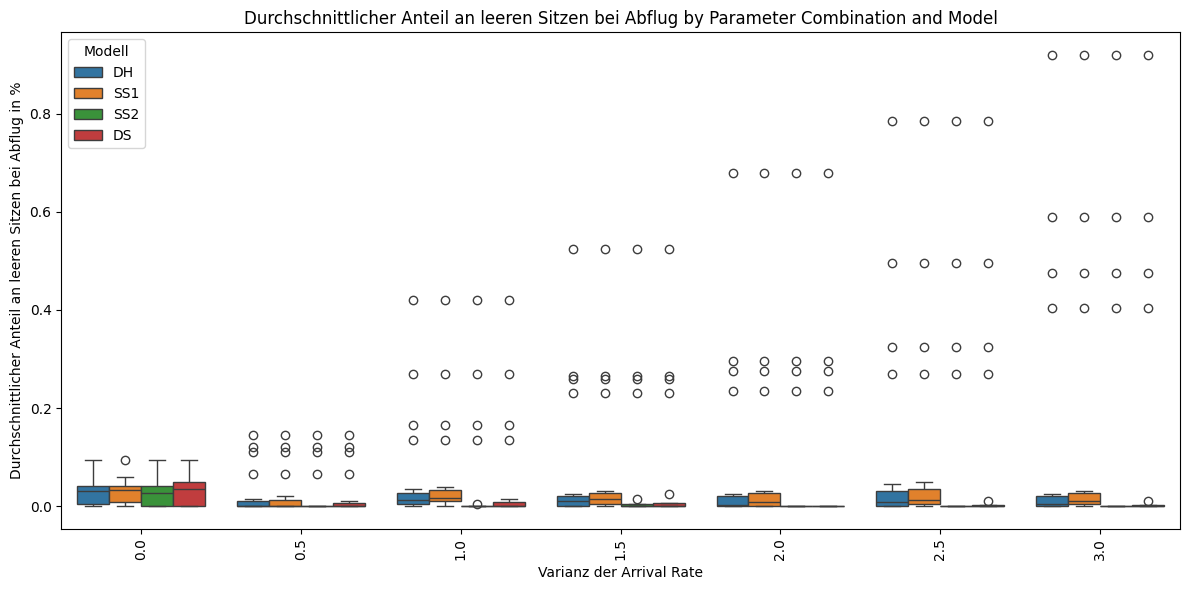

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

df_results_storage_show_rate = df_results_storage[(df_results_storage['show_variance']==0) & (df_results_storage['cancellation_variance'] == 0)]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'model']).mean()
# Create the boxplot
sns.boxplot(x='arrival_variance', y='Unused Inventory', hue='Modell',data=df_results_storage_show_rate)

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)
#plt.ylim(4000, 32500)

# Set plot title and labels
plt.title('Durchschnittlicher Anteil an leeren Sitzen bei Abflug by Parameter Combination and Model')
plt.xlabel('Varianz der Arrival Rate')
plt.ylabel('Durchschnittlicher Anteil an leeren Sitzen bei Abflug in %')
plt.legend(title='Modell')

# Show the plot
plt.tight_layout()
plt.show()

##### Lets Plot

In [35]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell', 'b_opt for all Classes']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
p

In [36]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell', 'b_opt for all Classes']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
p

### Cancellation Rate

#### Total Revenue

##### Matplot

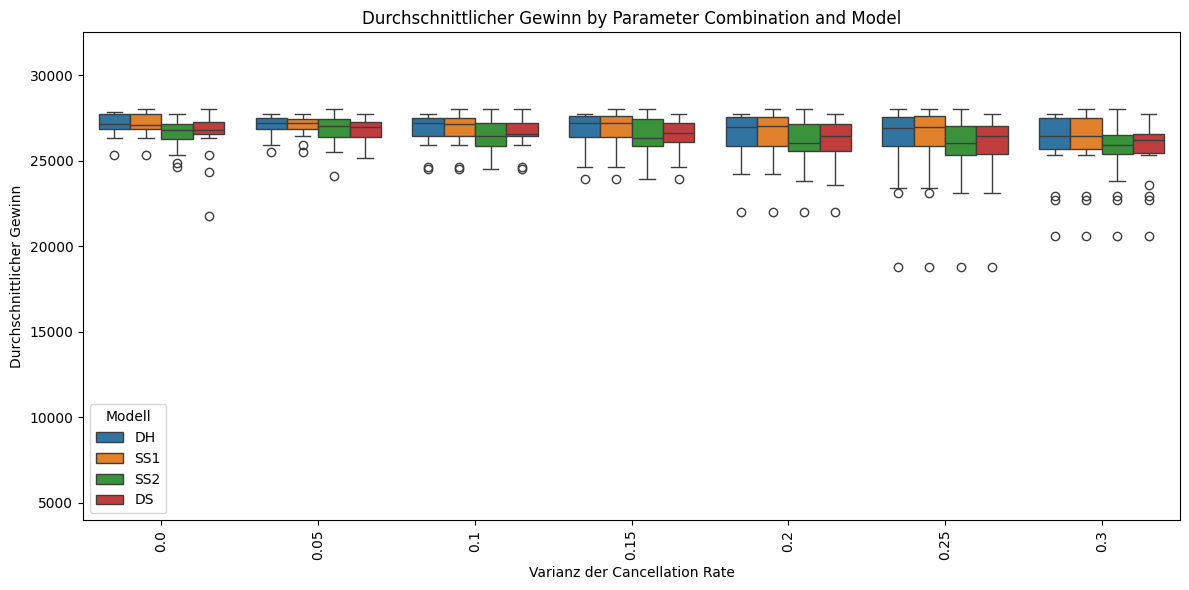

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

df_results_storage_show_rate = df_results_storage[(df_results_storage['show_variance']==0) & (df_results_storage['arrival_variance'] == 0)]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'model']).mean()
# Create the boxplot
sns.boxplot(x='cancellation_variance', y='Total Revenue', hue='Modell',data=df_results_storage_show_rate)

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)
plt.ylim(4000, 32500)

# Set plot title and labels
plt.title('Durchschnittlicher Gewinn by Parameter Combination and Model')
plt.xlabel('Varianz der Cancellation Rate')
plt.ylabel('Durchschnittlicher Gewinn')
plt.legend(title='Modell')

# Show the plot
plt.tight_layout()
plt.show()

##### Lets Plot

In [38]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['arrival_variance'] == 0)
].groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell', 'b_opt for all Classes']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))

# Display the plot
p

In [39]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['arrival_variance'] == 0)
]#.groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell', 'b_opt for all Classes']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))

# Display the plot
p

#### Denied Boardings

##### Matplot

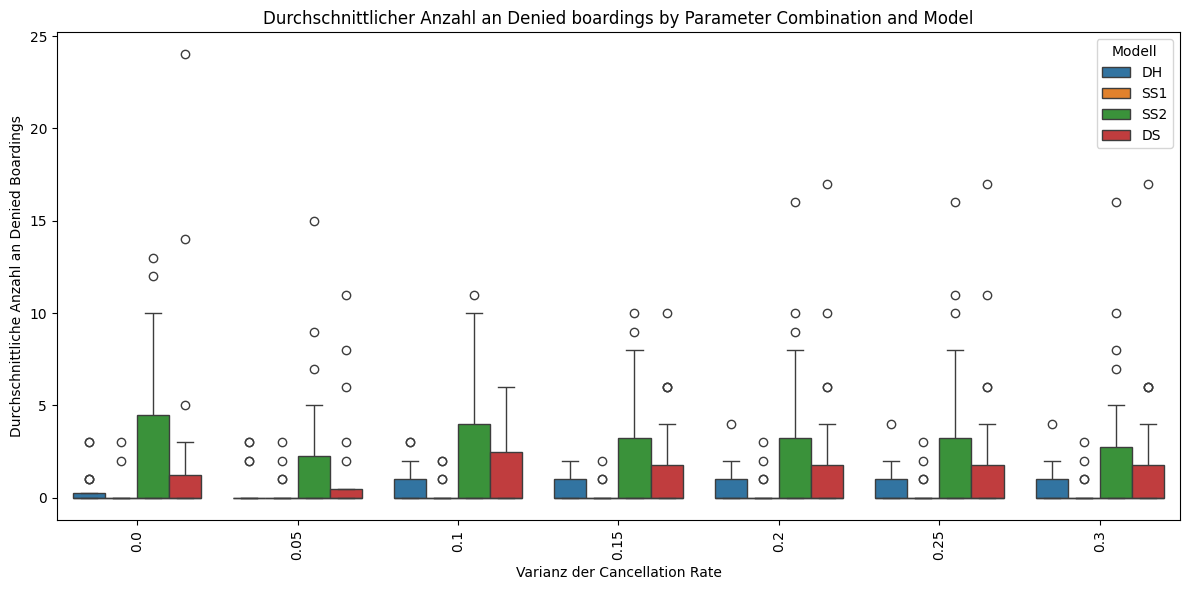

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

df_results_storage_show_rate = df_results_storage[(df_results_storage['show_variance']==0) & (df_results_storage['arrival_variance'] == 0)]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'model']).mean()
# Create the boxplot
sns.boxplot(x='cancellation_variance', y='Denied boardings', hue='Modell',data=df_results_storage_show_rate)

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)
#plt.ylim(4000, 32500)

# Set plot title and labels
plt.title('Durchschnittlicher Anzahl an Denied boardings by Parameter Combination and Model')
plt.xlabel('Varianz der Cancellation Rate')
plt.ylabel('Durchschnittliche Anzahl an Denied Boardings')
plt.legend(title='Modell')

# Show the plot
plt.tight_layout()
plt.show()

##### Lets Plot

In [41]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['arrival_variance'] == 0)
].groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell', 'b_opt for all Classes']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
p

In [42]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['arrival_variance'] == 0)
]#.groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell', 'b_opt for all Classes']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
p

#### Unused Inventory

##### Matplot

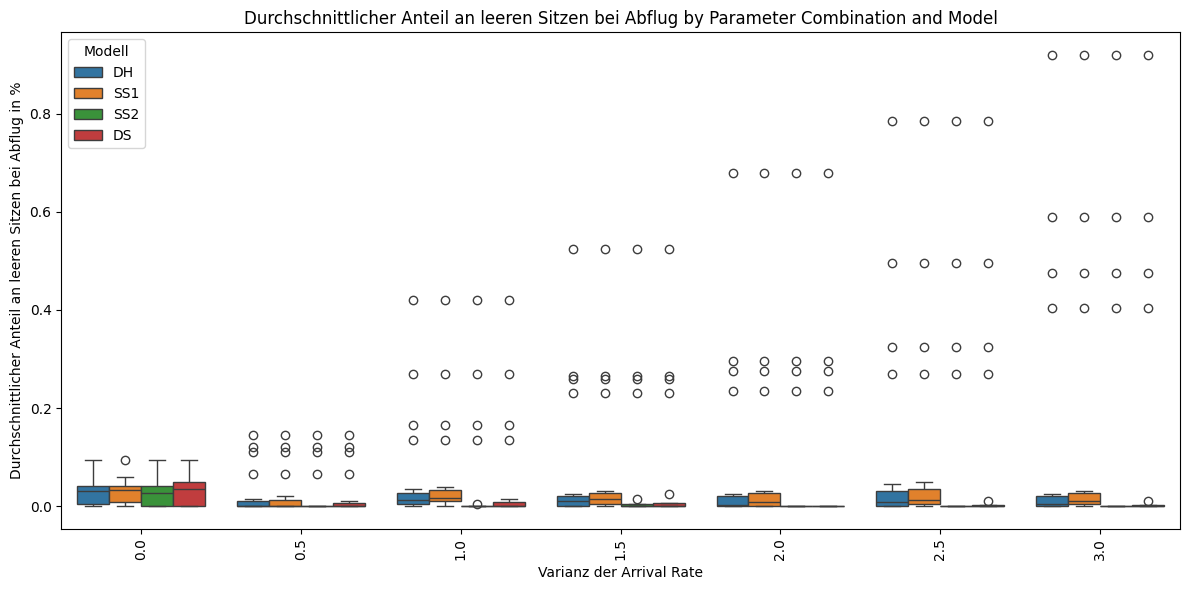

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

df_results_storage_show_rate = df_results_storage[(df_results_storage['show_variance']==0) & (df_results_storage['cancellation_variance'] == 0)]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'model']).mean()
# Create the boxplot
sns.boxplot(x='arrival_variance', y='Unused Inventory', hue='Modell',data=df_results_storage_show_rate)

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)
#plt.ylim(4000, 32500)

# Set plot title and labels
plt.title('Durchschnittlicher Anteil an leeren Sitzen bei Abflug by Parameter Combination and Model')
plt.xlabel('Varianz der Arrival Rate')
plt.ylabel('Durchschnittlicher Anteil an leeren Sitzen bei Abflug in %')
plt.legend(title='Modell')

# Show the plot
plt.tight_layout()
plt.show()

##### Lets Plot

In [44]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['arrival_variance'] == 0)
].groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell', 'b_opt for all Classes']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
p

In [45]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['arrival_variance'] == 0)
]#.groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell', 'b_opt for all Classes']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
p

# Simulation Multiple Fare Class

## Modellparameter

### Parameter

In [46]:
C = 200
max_limit = 300
theta = 400
r_list_s = [330, 140]
beta_s_list = [0.9, 0.95]
beta_c_list = [0.1, 0.05]
alpha_list = [0.7, 0.35]
p_list = [0.16, 0.84]
### Static
demand_list = [38, 202]

### Dynamic
p_0 = 0.05
kappa = 140
K = 100
T = 100
h = T/K
r_list_d = [0, 330, 140]
lambda_c = 0.05
f_list = [0, 0.16, 0.84]
beta_s = np.mean(beta_s_list)



### Optimale Buchungslimits

In [47]:
b_sm1 = static_multiple_1(C, r_list_s, beta_s_list, alpha_list, theta, beta_c_list, p_list, max_limit)
b_sm2 = static_multiple_2(C, r_list_s, beta_s, theta, demand_list, max_limit)
b_sm3 = static_multiple_3(C, r_list_s, alpha_list, beta_s_list, theta, demand_list, max_limit)
b_dm = dynamic_multiple(C, r_list_d, beta_s, p_0, f_list, theta, kappa, K, max_limit, lambda_c, h)
multiple_b_opt = {"SM1" : b_sm1, "SM2" : b_sm2, "SM3" : b_sm3, "DM" : b_dm}
print(multiple_b_opt)

{'SM1': 212, 'SM2': [217, 178], 'SM3': [198, 174], 'DM': [[300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 300], [300, 

## Simulationsparameter

In [48]:
T = 100
K = 100
h = T/K
results = {}

refunds = [0.7, 0.35]
revenues = [330, 140]
theta = 400
results_storage = {}
total_arrivals_cancellations = {}

## Ausführung

In [49]:
arrival_mean = 2.4
cancellation_mean = [0.1, 0.05]
show_mean = [0.9, 0.95]
show_variances = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
arrival_variances = [0.0, 0.5, 1, 1.5, 2, 2.5, 3]
cancellation_variances = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
#fare_class_probs = [0.9, 0.1]
results_storage = {}
total_arrivals_cancellations = {}
mylist = []


def calc_fare_class_probs(p_0, k):
    prob_class_0 = round((1-p_0) * (0.1 + 0.8 / (1 + np.exp(-0.07 * (k - 80)))),5)  # Starts at 0.1, max at 0.8
    prob_class_1 = 1 - p_0 - prob_class_0  # Growth for fare class 2 with a cap
    text = f"k: {k}, 0: {prob_class_0}, 1: {prob_class_1}"
    if not text in mylist:
        mylist.append(text)
    return prob_class_0, prob_class_1, p_0

samples = 20
for show_variance in show_variances:
    for arrival_variance in arrival_variances:
      for cancellation_variance in cancellation_variances:
            results_over_samples = {}
            arrivals_cancellations = {}
            for sample in range(1,samples+1):
                random_seed = sample
                np.random.seed(random_seed)
                results = {}
                arrivals_per_k = np.zeros((K))
                cancellations_per_k = np.zeros((K))
                arrivals_cancellations[sample] = {"Arrivals" : arrivals_per_k, "Cancellations" : cancellations_per_k}
                arrival_rate = max(np.random.normal(arrival_mean, arrival_variance),0)
                p_0 = np.exp(-arrival_mean*h)
                cancellation_rate = [max(np.random.normal(mean, cancellation_variance), 0) for mean in cancellation_mean]
                show_probs = [min(np.random.normal(mean, show_variance), 1) for mean in show_mean]
                for b_opt in multiple_b_opt.keys():
                    np.random.seed(random_seed)
                    reservations = 0
                    reservations_per_class = np.zeros(len(show_mean))
                    cancellations_per_class = np.zeros(len(show_mean))
                    arrivals_per_class = np.zeros(len(show_mean))
                    revenue = 0
                    for k in range(K):
                        arrivals = np.random.poisson(arrival_rate)
                        arrivals_per_k[k] = arrivals
                        if b_opt == "DM":
                            for _ in range(arrivals):
                                fare_class_probs = list(calc_fare_class_probs(p_0, k))
                                fare_class = np.random.choice(len(fare_class_probs), p=fare_class_probs)
                                if not fare_class == 2:
                                  arrivals_per_class[fare_class] += 1
                                  if reservations_per_class[fare_class] < multiple_b_opt[b_opt][k][fare_class]:
                                      reservations += 1
                                      reservations_per_class[fare_class] += 1
                                      revenue += revenues[fare_class]
                            for i in range(len(revenues)):
                                cancellations = np.random.poisson(cancellation_rate[i])
                                cancellations_per_k[k] += cancellations
                                reservations_per_class[i] -= cancellations
                                revenue -= cancellations * revenues[i] * refunds[i]
                                cancellations_per_class[i] += cancellations
                        elif b_opt == "SM1":
                            for _ in range(arrivals):
                                fare_class_probs = list(calc_fare_class_probs(p_0, k))
                                fare_class = np.random.choice(len(fare_class_probs), p=fare_class_probs)
                                if not fare_class == 2:
                                  arrivals_per_class[fare_class] += 1
                                  if np.sum(reservations_per_class) < multiple_b_opt[b_opt]:
                                      reservations += 1
                                      reservations_per_class[fare_class] += 1
                                      revenue += revenues[fare_class]
                            for i in range(len(revenues)):
                                cancellations = np.random.poisson(cancellation_rate[i])
                                cancellations_per_k[k] += cancellations
                                reservations_per_class[i] -= cancellations
                                revenue -= cancellations * revenues[i] * refunds[i]
                                cancellations_per_class[i] += cancellations
                        else:
                            for _ in range(arrivals):
                                fare_class_probs = list(calc_fare_class_probs(p_0, k))
                                fare_class = np.random.choice(len(fare_class_probs), p=fare_class_probs)
                                if not fare_class == 2:
                                  arrivals_per_class[fare_class] += 1
                                  if reservations_per_class[fare_class] < multiple_b_opt[b_opt][fare_class]:
                                      reservations += 1
                                      reservations_per_class[fare_class] += 1
                                      revenue += revenues[fare_class]
                            for i in range(len(revenues)):
                                cancellations = np.random.poisson(cancellation_rate[i])
                                cancellations_per_k[k] += cancellations
                                reservations_per_class[i] -= cancellations
                                revenue -= cancellations * revenues[i] * refunds[i]
                                cancellations_per_class[i] += cancellations


                    shows_per_class = np.zeros(len(fare_class_probs))
                    for i in range(len(revenues)):
                        shows_per_class[i] += np.random.binomial(max(reservations_per_class[i],0),show_probs[i])

                    total_revenue = 0
                    revenue_loss = 0
                    for i in range(len(revenues)):
                        total_revenue += shows_per_class[i] * revenues[i]
                        #total_revenue += reservations_per_class[i] * revenues[i]
                    total_revenue -= theta * max(np.sum(shows_per_class)-C, 0)
                    revenue_loss = max(C - np.sum(shows_per_class),0) * (np.sum(revenues)/len(revenues))
                    #revenue_loss = max(C - np.sum(reservations_per_class),0) * np.sum(revenues)/len(revenues)
                    unused_inventory = (max(C - np.sum(shows_per_class),0)/C)
                    results[b_opt] = {"b_opt": multiple_b_opt[b_opt], "Arrivals per Class" : arrivals_per_class, "Cancellations per Class" : cancellations_per_class, "Total Revenue" : total_revenue, "Expected Revenue Loss" : revenue_loss, "Unused Inventory" : unused_inventory, "Accepted Reservations per Class" : reservations_per_class, "Shows at Departure" : np.sum(shows_per_class), "Denied boardings" : max(np.sum(shows_per_class)-C,0), "Denied boarding Costs" : max(np.sum(shows_per_class)-C,0) * theta}
                results_over_samples[sample] = results
            results_storage[(show_variance, arrival_variance, cancellation_variance, tuple(fare_class_probs))] = results_over_samples
            total_arrivals_cancellations[(show_variance, arrival_variance, cancellation_variance, tuple(fare_class_probs))] = arrivals_cancellations

#for results in results_storage:
#    print(f"{results}: {results_storage[results]}")


## Als Dataframe umwandeln

In [50]:
import pandas as pd

# Initialize an empty list to hold all rows of data
data_rows = []
# Iterate over the results_storage dictionary to extract and flatten the data
for param_key, results_by_b_opt in results_storage.items():
    # Unpack the parameter key (which is a tuple of arrival_rate, cancellation_rate, and fare_class_probs)
    show_variance, arrival_variance, cancellation_variance, fare_class_probs = param_key

    # Iterate over each b_opt and its corresponding results
    for sample, results_by_model in results_by_b_opt.items():
        for model, result_metrics in results_by_model.items(): # Access the innermost dictionary
            # Create a dictionary for this row of data
            row_data = {
                'show_variance': show_variance,
                'arrival_variance': arrival_variance,
                'cancellation_variance': cancellation_variance,
                'fare_class_probs_1': fare_class_probs[0],
                'fare_class_probs_2': fare_class_probs[1],
                #'show_rate_1': show_probs_list[0],
                #'show_rate_2': show_probs_list[1],
                'sample': sample,
                'Modell': model, # Include the model information
                'Total Revenue': result_metrics['Total Revenue'],
                'Unused Inventory': result_metrics['Unused Inventory'],
                'Expected Revenue Loss': result_metrics['Expected Revenue Loss'],
                'Shows at Departure': result_metrics['Shows at Departure'],
                'Denied boardings': result_metrics['Denied boardings'],
                'Denied boarding Costs': result_metrics['Denied boarding Costs'],
            }
            #print(result_metrics['b_opt'])
            # Add per-class metrics to the row (assuming 2 fare classes here)
            if model == 'SM1': #or model == 'b_dh_m':
                row_data['b_opt for all Classes'] = result_metrics['b_opt']
            elif model == 'DM':
                b_opt_1 = []
                b_opt_2 = []
                for i in range(len(result_metrics['b_opt'])):
                      b_opt_1.append(result_metrics['b_opt'][i][0])
                      b_opt_2.append(result_metrics['b_opt'][i][1])
                row_data['b_opt for Class 1'] = b_opt_1
                row_data['b_opt for Class 2'] = b_opt_2
            else:
                row_data['b_opt for Class 1'] = result_metrics['b_opt'][0]
                row_data['b_opt for Class 2'] = result_metrics['b_opt'][1]
            row_data['Arrivals per Class 1'] = result_metrics['Arrivals per Class'][0]
            row_data['Arrivals per Class 2'] = result_metrics['Arrivals per Class'][1]
            row_data['Cancellations per Class 1'] = result_metrics['Cancellations per Class'][0]
            row_data['Cancellations per Class 2'] = result_metrics['Cancellations per Class'][1]
            row_data['Accepted Reservations per Class 1'] = result_metrics['Accepted Reservations per Class'][0]
            row_data['Accepted Reservations per Class 2'] = result_metrics['Accepted Reservations per Class'][1]

            # Append the row data to the list
            data_rows.append(row_data)

# Convert the list of dictionaries into a pandas DataFrame
df_results_storage = pd.DataFrame(data_rows)
df_results_storage['b_opt for all Classes'] = df_results_storage['b_opt for all Classes'].apply(lambda x: sum(x)/len(x) if isinstance(x, list) else x)
df_results_storage['b_opt for Class 1'] = df_results_storage['b_opt for Class 1'].apply(lambda x: sum(x)/len(x) if isinstance(x, list) else x)
df_results_storage['b_opt for Class 2'] = df_results_storage['b_opt for Class 2'].apply(lambda x: sum(x)/len(x) if isinstance(x, list) else x)
df_results_storage.tail(10)
#df_results_storage[df_results_storage['show_variance']==0]# and df_results_storage['variance']==0]
#df_results_storage.groupby(['arrival_rate', 'cancellation_rate_1', 'cancellation_rate_2', 'fare_class_probs_1', 'fare_class_probs_2', 'model']).mean()
#df_results_storage.sort_values(['arrival_rate', 'cancellation_rate_1', 'cancellation_rate_2', 'fare_class_probs_1', 'fare_class_probs_2', 'model'])

,show_variance,arrival_variance,cancellation_variance,fare_class_probs_1,fare_class_probs_2,sample,Modell,Total Revenue,Unused Inventory,Expected Revenue Loss,...,Denied boarding Costs,b_opt for all Classes,Arrivals per Class 1,Arrivals per Class 2,Cancellations per Class 1,Cancellations per Class 2,Accepted Reservations per Class 1,Accepted Reservations per Class 2,b_opt for Class 1,b_opt for Class 2
27430,0.3,3.0,0.3,0.66621,0.243072,18,SM3,21840.0,0.220,10340.0,...,0.0,NaN,66.0,159.0,74.0,3.0,-8.0,156.0,198.00,174.00
27431,0.3,3.0,0.3,0.66621,0.243072,18,DM,21840.0,0.220,10340.0,...,0.0,NaN,66.0,159.0,74.0,3.0,-8.0,156.0,297.65,297.41
27432,0.3,3.0,0.3,0.66621,0.243072,19,SM1,30710.0,0.195,9165.0,...,0.0,212.0,75.0,178.0,0.0,0.0,50.0,162.0,NaN,NaN
27433,0.3,3.0,0.3,0.66621,0.243072,19,SM2,38850.0,0.040,1880.0,...,0.0,NaN,75.0,178.0,0.0,0.0,75.0,178.0,217.00,178.00
27434,0.3,3.0,0.3,0.66621,0.243072,19,SM3,38430.0,0.055,2585.0,...,0.0,NaN,75.0,178.0,0.0,0.0,75.0,174.0,198.00,174.00
27435,0.3,3.0,0.3,0.66621,0.243072,19,DM,38850.0,0.040,1880.0,...,0.0,NaN,75.0,178.0,0.0,0.0,75.0,178.0,297.65,297.41
27436,0.3,3.0,0.3,0.66621,0.243072,20,SM1,19150.0,0.350,16450.0,...,0.0,212.0,139.0,323.0,8.0,12.0,22.0,190.0,NaN,NaN
27437,0.3,3.0,0.3,0.66621,0.243072,20,SM2,25950.0,0.270,12690.0,...,0.0,NaN,139.0,323.0,8.0,12.0,131.0,178.0,217.00,178.00
27438,0.3,3.0,0.3,0.66621,0.243072,20,SM3,25670.0,0.280,13160.0,...,0.0,NaN,139.0,323.0,8.0,12.0,131.0,174.0,198.00,174.00
27439,0.3,3.0,0.3,0.66621,0.243072,20,DM,27270.0,0.000,0.0,...,9600.0,NaN,139.0,323.0,8.0,12.0,131.0,299.0,297.65,297.41


## Visualisierung

### Show Rate

#### Total Revenue

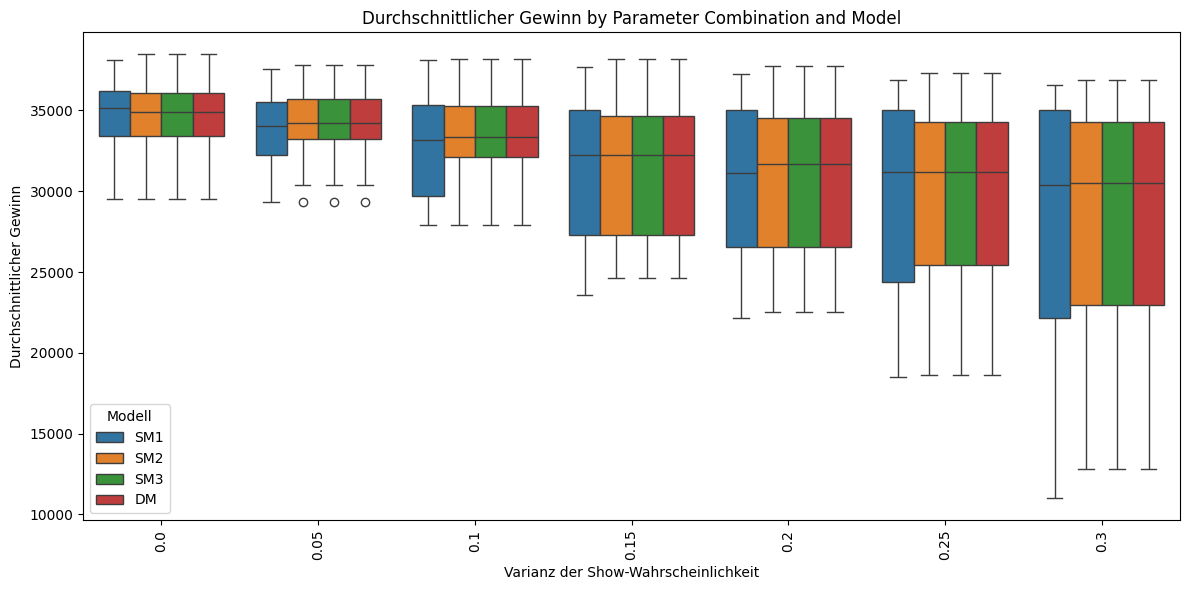

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

df_results_storage_show_rate = df_results_storage[(df_results_storage['arrival_variance']==0) & (df_results_storage['cancellation_variance'] == 0)]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean()
# Create the boxplot
sns.boxplot(x='show_variance', y='Total Revenue', hue='Modell',data=df_results_storage_show_rate)

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)

# Set plot title and labels
plt.title('Durchschnittlicher Gewinn by Parameter Combination and Model')
plt.xlabel('Varianz der Show-Wahrscheinlichkeit')
plt.ylabel('Durchschnittlicher Gewinn')
plt.legend(title='Modell')

# Show the plot
plt.tight_layout()
plt.show()

In [52]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='m_show_revenue.pdf')
# Display the plot
p

In [53]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell', 'b_opt for all Classes']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='m_show_revenue_box.pdf')
# Display the plot
p

#### Denied Boardings

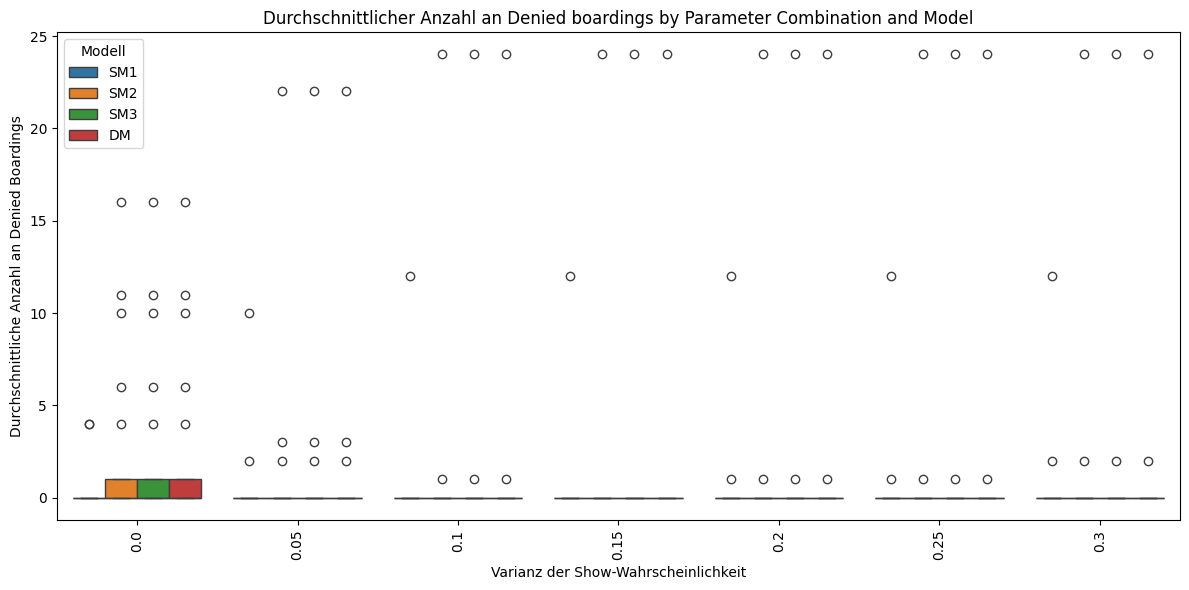

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

df_results_storage_show_rate = df_results_storage[(df_results_storage['arrival_variance']==0) & (df_results_storage['cancellation_variance'] == 0)]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'model']).mean()
# Create the boxplot
sns.boxplot(x='show_variance', y='Denied boardings', hue='Modell',data=df_results_storage_show_rate)

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)
#plt.ylim(4000, 32500)

# Set plot title and labels
plt.title('Durchschnittlicher Anzahl an Denied boardings by Parameter Combination and Model')
plt.xlabel('Varianz der Show-Wahrscheinlichkeit')
plt.ylabel('Durchschnittliche Anzahl an Denied Boardings')
plt.legend(title='Modell')

# Show the plot
plt.tight_layout()
plt.show()

In [55]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
#ggsave(p, filename='m_show_db.pdf')
p

In [56]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell', 'b_opt for all Classes']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='m_show_db_box.pdf')
# Display the plot
p

#### Unused Inventory

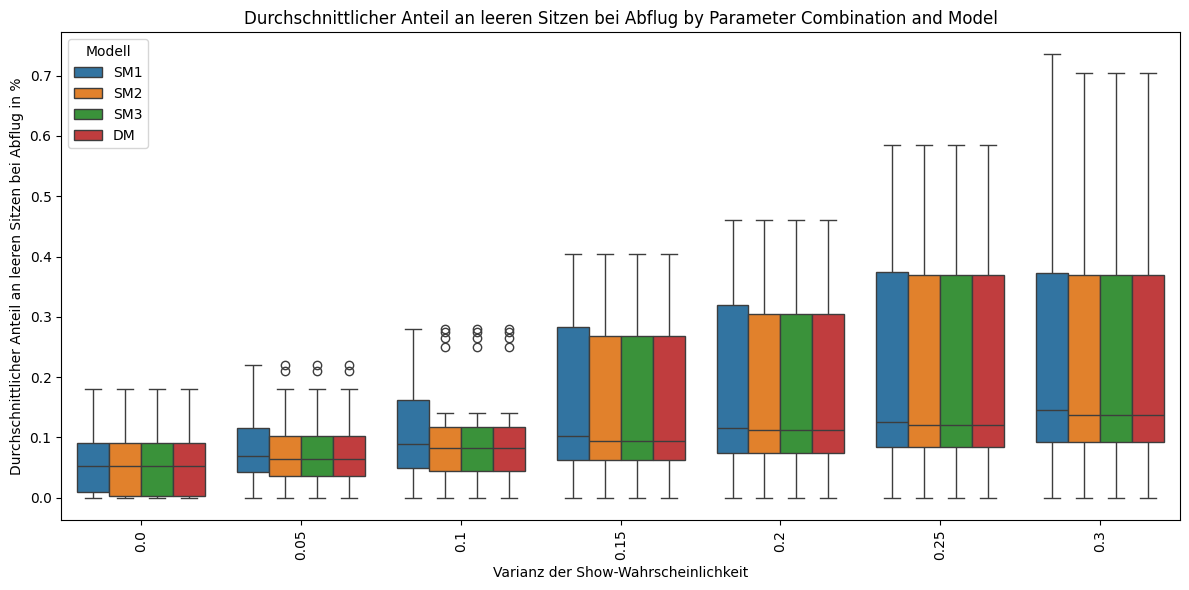

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

df_results_storage_show_rate = df_results_storage[(df_results_storage['arrival_variance']==0) & (df_results_storage['cancellation_variance'] == 0)]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'model']).mean()
# Create the boxplot
sns.boxplot(x='show_variance', y='Unused Inventory', hue='Modell',data=df_results_storage_show_rate)

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)
#plt.ylim(4000, 32500)

# Set plot title and labels
plt.title('Durchschnittlicher Anteil an leeren Sitzen bei Abflug by Parameter Combination and Model')
plt.xlabel('Varianz der Show-Wahrscheinlichkeit')
plt.ylabel('Durchschnittlicher Anteil an leeren Sitzen bei Abflug in %')
plt.legend(title='Modell')

# Show the plot
plt.tight_layout()
plt.show()

In [58]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
#ggsave(p, filename='m_show_inventory.pdf')
p

In [59]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell', 'b_opt for all Classes']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
#ggsave(p, filename='m_show_inventory_box.pdf')
p

### Arrival Rate

#### Total Revenue

In [60]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='m_arrival_revenue.pdf')
# Display the plot
p

In [61]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='m_arrival_revenue_box.pdf')
# Display the plot
p

#### Denied Boardings

In [62]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='m_arrival_db.pdf')
# Display the plot
p

In [63]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='m_arrival_db_box.pdf')
# Display the plot
p

#### Unused Inventory

In [64]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
#ggsave(p, filename='m_arrival_inventory.pdf')
p

In [65]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
#ggsave(p, filename='m_arrival_inventory_box.pdf')
p

### Cancellation Rate

#### Total Revenue

In [66]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['show_variance'] == 0)
].groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='m_cancellation_revenue.pdf')
# Display the plot
p

In [67]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['show_variance'] == 0)
]#.groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='m_cancellation_revenue_box.pdf')
# Display the plot
p

#### Denied Boardings

In [68]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['show_variance'] == 0)
].groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
#ggsave(p, filename='m_cancellation_db.pdf')
p

In [69]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['show_variance'] == 0)
]#.groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
#ggsave(p, filename='m_cancellation_db_box.pdf')
p

#### Unused Inventory

In [70]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['show_variance'] == 0)
].groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
#ggsave(p, filename='m_cancellation_inventory.pdf')
p

In [71]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['show_variance'] == 0)
]#.groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
#ggsave(p, filename='m_cancellation_inventory_box.pdf')
p

# Kombinierte Simulation mit einer Tarifklasse

## Modellparameter

### Parameter

In [72]:
C = 200
max_limit = 300
theta = 400

###### Multiple Fare Class
r_list_s = [140]
beta_s_list = [0.95]
beta_c_list = [0.05]
alpha_list = [1]
p_list = [1]
### Static
demand_list = [240]

### Dynamic
p_0 = 0.05
kappa = 140
K = 100
T = 100
h = T/K
r_list_d = [0, 140]
lambda_c = 0.05
f_list = [0, 1]
beta_s = np.mean(beta_s_list)

####### Single Fare Class
### Static
r = 140
beta_s = 0.95
beta_c = 0.05
demand = 240
### Dynamic
lambda_d = 2.4
K = 100
kappa = 140

### Optimale Buchungslimits

In [73]:
b_dh = deterministic(C, beta_s)
b_ss1 = static_single_1(C, theta, r, beta_s, max_limit)
b_ss2 = static_single_2(C, theta, r, demand, max_limit)
b_sm1 = static_multiple_1(C, r_list_s, beta_s_list, alpha_list, theta, beta_c_list, p_list, max_limit)
b_sm2 = static_multiple_2(C, r_list_s, beta_s, theta, demand_list, max_limit)
b_sm3 = static_multiple_3(C, r_list_s, alpha_list, beta_s_list, theta, demand_list, max_limit)
b_ds = dynamic_single(C, r, beta_c, theta, lambda_d, kappa, K, max_limit)
b_dm = dynamic_multiple(C, r_list_d, beta_s, p_0, f_list, theta, kappa, K, max_limit, lambda_c, h)
combined_b_opt_single = {"DH" : b_dh, "SS1": b_ss1, "SS2" : b_ss2, "SM1" : b_sm1, "SM2" : b_sm2, "SM3" : b_sm3, "DS" : b_ds, "DM" : b_dm}
print(combined_b_opt_single)

{'DH': 210, 'SS1': 209, 'SS2': 222, 'SM1': 209, 'SM2': [210], 'SM3': [210], 'DS': [300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 291, 276, 262, 248, 235, 223, 211, 200], 'DM': [[300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [300], [30

## Simulationsparameter

In [74]:
T = 100
K = 100
h = T/K
results = {}

refunds = [1]
revenues = [140]
theta = 400
results_storage = {}
total_arrivals_cancellations = {}

## Ausführung

In [75]:
arrival_mean = 2.4
cancellation_mean = [0.05]
show_mean = [0.95]
show_variances = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
arrival_variances = [0.0, 0.5, 1, 1.5, 2, 2.5, 3]
cancellation_variances = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
#fare_class_probs = [0.9, 0.1]
results_storage = {}
total_arrivals_cancellations = {}
mylist = []


def calc_fare_class_probs(p_0):
    return 1 - p_0, p_0

samples = 20
for show_variance in show_variances:
    for arrival_variance in arrival_variances:
      for cancellation_variance in cancellation_variances:
            results_over_samples = {}
            arrivals_cancellations = {}
            for sample in range(1,samples+1):
                random_seed = sample
                np.random.seed(random_seed)
                results = {}
                arrivals_per_k = np.zeros((K))
                cancellations_per_k = np.zeros((K))
                arrivals_cancellations[sample] = {"Arrivals" : arrivals_per_k, "Cancellations" : cancellations_per_k}
                arrival_rate = max(np.random.normal(arrival_mean, arrival_variance),0)
                p_0 = np.exp(-arrival_mean*h)
                cancellation_rate = [max(np.random.normal(mean, cancellation_variance), 0) for mean in cancellation_mean]
                show_probs = [min(np.random.normal(mean, show_variance), 1) for mean in show_mean]
                for b_opt in combined_b_opt_single.keys():
                    np.random.seed(random_seed)
                    reservations = 0
                    reservations_per_class = np.zeros(len(show_mean))
                    cancellations_per_class = np.zeros(len(show_mean))
                    arrivals_per_class = np.zeros(len(show_mean))
                    revenue = 0
                    for k in range(K):
                        arrivals = np.random.poisson(arrival_rate)
                        arrivals_per_k[k] = arrivals
                        if b_opt == "DS":
                            for _ in range(arrivals):
                                fare_class_probs = list(calc_fare_class_probs(p_0))
                                fare_class = np.random.choice(len(fare_class_probs), p=fare_class_probs)
                                if not fare_class == 1:
                                  arrivals_per_class[fare_class] += 1
                                  if np.sum(reservations_per_class) < combined_b_opt_single[b_opt][k]:
                                      reservations += 1
                                      reservations_per_class[fare_class] += 1
                                      revenue += revenues[fare_class]
                            for i in range(len(revenues)):
                                cancellations = np.random.poisson(cancellation_rate[i])
                                cancellations_per_k[k] += cancellations
                                reservations_per_class[i] -= cancellations
                                revenue -= cancellations * revenues[i] * refunds[i]
                                cancellations_per_class[i] += cancellations
                        elif b_opt == "DM":
                            for _ in range(arrivals):
                                fare_class_probs = list(calc_fare_class_probs(p_0))
                                fare_class = np.random.choice(len(fare_class_probs), p=fare_class_probs)
                                if not fare_class == 1:
                                  arrivals_per_class[fare_class] += 1
                                  if np.sum(reservations_per_class) < combined_b_opt_single[b_opt][k][fare_class]:
                                      reservations += 1
                                      reservations_per_class[fare_class] += 1
                                      revenue += revenues[fare_class]
                            for i in range(len(revenues)):
                                cancellations = np.random.poisson(cancellation_rate[i])
                                cancellations_per_k[k] += cancellations
                                reservations_per_class[i] -= cancellations
                                revenue -= cancellations * revenues[i] * refunds[i]
                                cancellations_per_class[i] += cancellations
                        elif b_opt == "SM2" or b_opt == "SM3" :
                            for _ in range(arrivals):
                                fare_class_probs = list(calc_fare_class_probs(p_0))
                                fare_class = np.random.choice(len(fare_class_probs), p=fare_class_probs)
                                if not fare_class == 1:
                                  arrivals_per_class[fare_class] += 1
                                  if np.sum(reservations_per_class) < combined_b_opt_single[b_opt][fare_class]:
                                      reservations += 1
                                      reservations_per_class[fare_class] += 1
                                      revenue += revenues[fare_class]
                            for i in range(len(revenues)):
                                cancellations = np.random.poisson(cancellation_rate[i])
                                cancellations_per_k[k] += cancellations
                                reservations_per_class[i] -= cancellations
                                revenue -= cancellations * revenues[i] * refunds[i]
                                cancellations_per_class[i] += cancellations
                        else:
                            for _ in range(arrivals):
                                fare_class_probs = list(calc_fare_class_probs(p_0))
                                fare_class = np.random.choice(len(fare_class_probs), p=fare_class_probs)
                                if not fare_class == 1:
                                  arrivals_per_class[fare_class] += 1
                                  if np.sum(reservations_per_class) < combined_b_opt_single[b_opt]:
                                      reservations += 1
                                      reservations_per_class[fare_class] += 1
                                      revenue += revenues[fare_class]
                            for i in range(len(revenues)):
                                cancellations = np.random.poisson(cancellation_rate[i])
                                cancellations_per_k[k] += cancellations
                                reservations_per_class[i] -= cancellations
                                revenue -= cancellations * revenues[i] * refunds[i]
                                cancellations_per_class[i] += cancellations


                    shows_per_class = np.zeros(len(fare_class_probs))
                    for i in range(len(revenues)):
                        shows_per_class[i] += np.random.binomial(max(reservations_per_class[i],0),show_probs[i])

                    total_revenue = 0
                    revenue_loss = 0
                    for i in range(len(revenues)):
                        total_revenue += shows_per_class[i] * revenues[i]
                        #total_revenue += reservations_per_class[i] * revenues[i]
                    total_revenue -= theta * max(np.sum(shows_per_class)-C, 0)
                    revenue_loss = max(C - np.sum(shows_per_class),0) * (np.sum(revenues)/len(revenues))
                    #revenue_loss = max(C - np.sum(reservations_per_class),0) * np.sum(revenues)/len(revenues)
                    unused_inventory = (max(C - np.sum(shows_per_class),0)/C)
                    results[b_opt] = {"b_opt": combined_b_opt_single[b_opt], "Arrivals per Class" : arrivals_per_class, "Cancellations per Class" : cancellations_per_class, "Total Revenue" : total_revenue, "Expected Revenue Loss" : revenue_loss, "Unused Inventory" : unused_inventory, "Accepted Reservations per Class" : reservations_per_class, "Shows at Departure" : np.sum(shows_per_class), "Denied boardings" : max(np.sum(shows_per_class)-C,0), "Denied boarding Costs" : max(np.sum(shows_per_class)-C,0) * theta}
                results_over_samples[sample] = results
            results_storage[(show_variance, arrival_variance, cancellation_variance, tuple(fare_class_probs))] = results_over_samples
            total_arrivals_cancellations[(show_variance, arrival_variance, cancellation_variance, tuple(fare_class_probs))] = arrivals_cancellations

#for results in results_storage:
#    print(f"{results}: {results_storage[results]}")

## Als Dataframe umwandeln

In [76]:
import pandas as pd

# Initialize an empty list to hold all rows of data
data_rows = []
# Iterate over the results_storage dictionary to extract and flatten the data
for param_key, results_by_b_opt in results_storage.items():
    # Unpack the parameter key (which is a tuple of arrival_rate, cancellation_rate, and fare_class_probs)
    show_variance, arrival_variance, cancellation_variance, fare_class_probs = param_key

    # Iterate over each b_opt and its corresponding results
    for sample, results_by_model in results_by_b_opt.items():
        for model, result_metrics in results_by_model.items(): # Access the innermost dictionary
            # Create a dictionary for this row of data
            row_data = {
                'show_variance': show_variance,
                'arrival_variance': arrival_variance,
                'cancellation_variance': cancellation_variance,
                'fare_class_probs_1': fare_class_probs[0],
                'fare_class_probs_2': fare_class_probs[1],
                #'show_rate_1': show_probs_list[0],
                #'show_rate_2': show_probs_list[1],
                'sample': sample,
                'Modell': model, # Include the model information
                'Total Revenue': result_metrics['Total Revenue'],
                'Unused Inventory': result_metrics['Unused Inventory'],
                'Expected Revenue Loss': result_metrics['Expected Revenue Loss'],
                'Shows at Departure': result_metrics['Shows at Departure'],
                'Denied boardings': result_metrics['Denied boardings'],
                'Denied boarding Costs': result_metrics['Denied boarding Costs'],
            }

            # Add per-class metrics to the row (assuming 2 fare classes here)
            if model == 'DM':
                b_opt_1 = []
                for i in range(len(result_metrics['b_opt'])):
                      b_opt_1.append(result_metrics['b_opt'][i][0])
                row_data['b_opt for Class 1'] = b_opt_1
            elif model == 'SM2' or model == 'SM3':
                row_data['b_opt for Class 1'] = result_metrics['b_opt'][0]
            else:
                row_data['b_opt for all Classes'] = result_metrics['b_opt']
            row_data['Arrivals per Class 1'] = result_metrics['Arrivals per Class'][0]
            row_data['Cancellations per Class 1'] = result_metrics['Cancellations per Class'][0]
            row_data['Accepted Reservations per Class 1'] = result_metrics['Accepted Reservations per Class'][0]

            # Append the row data to the list
            data_rows.append(row_data)

# Convert the list of dictionaries into a pandas DataFrame
df_results_storage = pd.DataFrame(data_rows)
df_results_storage['b_opt for all Classes'] = df_results_storage['b_opt for all Classes'].apply(lambda x: sum(x)/len(x) if isinstance(x, list) else x)
df_results_storage['b_opt for Class 1'] = df_results_storage['b_opt for Class 1'].apply(lambda x: sum(x)/len(x) if isinstance(x, list) else x)
df_results_storage.head(10)
#df_results_storage[df_results_storage['show_variance']==0]# and df_results_storage['variance']==0]
#df_results_storage.groupby(['arrival_rate', 'cancellation_rate_1', 'cancellation_rate_2', 'fare_class_probs_1', 'fare_class_probs_2', 'model']).mean()
#df_results_storage.sort_values(['arrival_rate', 'cancellation_rate_1', 'cancellation_rate_2', 'fare_class_probs_1', 'fare_class_probs_2', 'model'])

,show_variance,arrival_variance,cancellation_variance,fare_class_probs_1,fare_class_probs_2,sample,Modell,Total Revenue,Unused Inventory,Expected Revenue Loss,Shows at Departure,Denied boardings,Denied boarding Costs,b_opt for all Classes,Arrivals per Class 1,Cancellations per Class 1,Accepted Reservations per Class 1,b_opt for Class 1
0,0.0,0.0,0.0,0.909282,0.090718,1,DH,27860.0,0.005,140.0,199.0,0.0,0.0,210.00,224.0,6.0,210.0,NaN
1,0.0,0.0,0.0,0.909282,0.090718,1,SS1,27720.0,0.010,280.0,198.0,0.0,0.0,209.00,224.0,6.0,209.0,NaN
2,0.0,0.0,0.0,0.909282,0.090718,1,SS2,26180.0,0.000,0.0,207.0,7.0,2800.0,222.00,224.0,6.0,218.0,NaN
3,0.0,0.0,0.0,0.909282,0.090718,1,SM1,27720.0,0.010,280.0,198.0,0.0,0.0,209.00,224.0,6.0,209.0,NaN
4,0.0,0.0,0.0,0.909282,0.090718,1,SM2,27860.0,0.005,140.0,199.0,0.0,0.0,NaN,224.0,6.0,210.0,210.00
5,0.0,0.0,0.0,0.909282,0.090718,1,SM3,27860.0,0.005,140.0,199.0,0.0,0.0,NaN,224.0,6.0,210.0,210.00
6,0.0,0.0,0.0,0.909282,0.090718,1,DS,27740.0,0.000,0.0,201.0,1.0,400.0,295.46,224.0,6.0,212.0,NaN
7,0.0,0.0,0.0,0.909282,0.090718,1,DM,26180.0,0.000,0.0,207.0,7.0,2800.0,NaN,224.0,6.0,218.0,296.95
8,0.0,0.0,0.0,0.909282,0.090718,2,DH,26880.0,0.040,1120.0,192.0,0.0,0.0,210.00,206.0,6.0,200.0,NaN
9,0.0,0.0,0.0,0.909282,0.090718,2,SS1,26880.0,0.040,1120.0,192.0,0.0,0.0,209.00,206.0,6.0,200.0,NaN


## Visualisierung

### Show Rate

#### Total Revenue

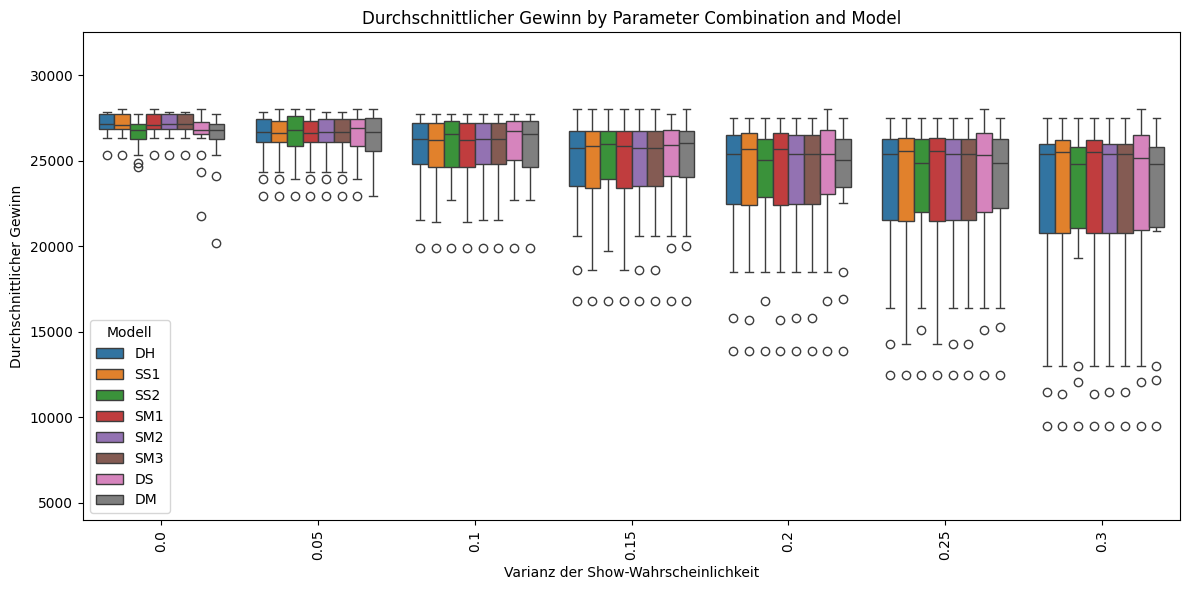

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

df_results_storage_show_rate = df_results_storage[(df_results_storage['arrival_variance']==0) & (df_results_storage['cancellation_variance'] == 0)]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'model']).mean()
# Create the boxplot
sns.boxplot(x='show_variance', y='Total Revenue', hue='Modell',data=df_results_storage_show_rate)

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)
plt.ylim(4000, 32500)

# Set plot title and labels
plt.title('Durchschnittlicher Gewinn by Parameter Combination and Model')
plt.xlabel('Varianz der Show-Wahrscheinlichkeit')
plt.ylabel('Durchschnittlicher Gewinn')
plt.legend(title='Modell')

# Show the plot
plt.tight_layout()
plt.show()

In [78]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()


# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#gsave(p, filename='cs_show_revenue.pdf')
# Display the plot
p

In [79]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()


# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cs_show_revenue_box.pdf')
# Display the plot
p

#### Denied Boardings

In [80]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cs_show_db.pdf')
# Display the plot
p

In [81]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cs_show_db_box.pdf')
# Display the plot
p

#### Unused Inventory

In [82]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cs_show_inventory.pdf')
# Display the plot
p

In [83]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cs_show_inventory_box.pdf')
# Display the plot
p

### Arrival Rate

#### Total Revenue

In [84]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cs_arrival_revenue.pdf')
# Display the plot
p

In [85]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cs_arrival_revenue_box.pdf')
# Display the plot
p

#### Denied boardings

In [86]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cs_arrival_db.pdf')
# Display the plot
p

In [87]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cs_arrival_db_box.pdf')
# Display the plot
p

#### Unused Inventory

In [88]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
#ggsave(p, filename='cs_arrival_inventory.pdf')
p

In [89]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
#ggsave(p, filename='cs_arrival_inventory_box.pdf')
p

### Cancellation Rate

#### Total Revenue

In [90]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['show_variance'] == 0)
].groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))

#ggsave(p, filename='cs_cancellation_revenue.pdf')
# Display the plot
p

In [91]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['show_variance'] == 0)
]#.groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))

#ggsave(p, filename='cs_cancellation_revenue_box.pdf')
# Display the plot
p

#### Denied Boardings

In [92]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['show_variance'] == 0)
].groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cs_cancellation_db.pdf')
# Display the plot
p

In [93]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['show_variance'] == 0)
]#.groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cs_cancellation_db_box.pdf')
# Display the plot
p

#### Unused Inventory

In [94]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['show_variance'] == 0)
].groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cs_cancellation_inventory.pdf')
# Display the plot
p

In [95]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['show_variance'] == 0)
]#.groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cs_cancellation_inventory_box.pdf')
# Display the plot
p

# Kombinierte Simulation mit mehreren Tarifklassen

## Modellparameter

### Parameter

In [96]:
C = 200
max_limit = 300
theta = 400

###### Multiple Fare Class
r_list_s = [330, 140]
beta_s_list = [0.9, 0.95]
beta_c_list = [0.1, 0.05]
alpha_list = [0.7, 0.35]
p_list = [0.16, 0.84]
### Static
demand_list = [38, 202]

### Dynamic
p_0 = 0.05
kappa = 140
K = 100
T = 100
h = T/K
r_list_d = [0, 330, 140]
lambda_c = 0.05
f_list = [0, 0.16, 0.84]
beta_s = np.mean(beta_s_list)
beta_c = np.mean(beta_c_list)
####### Single Fare Class
### Static

### Dynamic
lambda_d = 2.4

### Optimale Buchungslimits

In [97]:
b_dh = deterministic(C, beta_s)
b_ss1 = static_single_1(C, theta, r, beta_s, max_limit)
b_ss2 = static_single_2(C, theta, r, demand, max_limit)
b_sm1 = static_multiple_1(C, r_list_s, beta_s_list, alpha_list, theta, beta_c_list, p_list, max_limit)
b_sm2 = static_multiple_2(C, r_list_s, beta_s, theta, demand_list, max_limit)
b_sm3 = static_multiple_3(C, r_list_s, alpha_list, beta_s_list, theta, demand_list, max_limit)
b_ds = dynamic_single(C, r, beta_c, theta, lambda_d, kappa, K, max_limit)
b_dm = dynamic_multiple(C, r_list_d, beta_s, p_0, f_list, theta, kappa, K, max_limit, lambda_c, h)
#combined_b_opt_multiple = {"b_sm1" : b_sm1, "b_sm2" : b_sm2, "b_sm3" : b_sm3, "b_dm" : b_dm}

In [98]:
C_list = []
for i in range(len(demand_list)):
    C_list.append(int(C * (demand_list[i]/np.sum(demand_list))))

b_ss1_m_list = []
for i in range(len(demand_list)):
    b_ss1_m_list.append(static_single_1(C_list[i], theta, r_list_s[i], beta_s, max_limit))

b_ss2_m_list = []
for i in range(len(demand_list)):
    b_ss2_m_list.append(static_single_2(C_list[i], theta, r_list_s[i], demand_list[i], max_limit))

b_dh_m_list = []
for i in range(len(demand_list)):
    b_dh_m_list.append(deterministic(C_list[i], beta_s))

b_ds_m_list = []
for i in range(len(demand_list)):
    b_ds_m_list.append(dynamic_single(C_list[i], r_list_s[i], beta_c, theta, lambda_d, kappa, K, max_limit))

combined_b_opt_multiple = {"DH_m" : b_dh_m_list, "SS1_m" : b_ss1_m_list, "SS2_m": b_ss2_m_list, "SM1" : b_sm1, "SM2" : b_sm2, "SM3" : b_sm3, "DS_m" : b_ds_m_list,  "DM" : b_dm}

print(combined_b_opt_multiple)

{'DH_m': [33, 181], 'SS1_m': [36, 180], 'SS2_m': [37, 186], 'SM1': 212, 'SM2': [217, 178], 'SM3': [198, 174], 'DS_m': [[300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 284, 224, 191, 104, 59, 54, 49, 45, 41, 37, 34, 31], [300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 3

## Simulationsparameter

In [99]:
T = 100
K = 100
h = T/K
results = {}

refunds = [0.7, 0.35]
revenues = [330, 140]
theta = 400
results_storage = {}
total_arrivals_cancellations = {}

## Ausführung

In [100]:
arrival_mean = 2.4
cancellation_mean = [0.1, 0.05]
show_mean = [0.9, 0.95]
show_variances = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
arrival_variances = [0.0, 0.5, 1, 1.5, 2, 2.5, 3]
cancellation_variances = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
#fare_class_probs = [0.9, 0.1]
results_storage = {}
total_arrivals_cancellations = {}
mylist = []


def calc_fare_class_probs(p_0, k):
    prob_class_0 = round((1-p_0) * (0.1 + 0.8 / (1 + np.exp(-0.07 * (k - 80)))),5)  # Starts at 0.1, max at 0.8
    prob_class_1 = 1 - p_0 - prob_class_0  # Growth for fare class 2 with a cap
    text = f"k: {k}, 0: {prob_class_0}, 1: {prob_class_1}"
    if not text in mylist:
        mylist.append(text)
    return prob_class_0, prob_class_1, p_0

samples = 20
for show_variance in show_variances:
    for arrival_variance in arrival_variances:
      for cancellation_variance in cancellation_variances:
            results_over_samples = {}
            arrivals_cancellations = {}
            for sample in range(1,samples+1):
                random_seed = sample
                np.random.seed(random_seed)
                results = {}
                arrivals_per_k = np.zeros((K))
                cancellations_per_k = np.zeros((K))
                arrivals_cancellations[sample] = {"Arrivals" : arrivals_per_k, "Cancellations" : cancellations_per_k}
                arrival_rate = max(np.random.normal(arrival_mean, arrival_variance),0)
                p_0 = np.exp(-arrival_mean*h)
                cancellation_rate = [max(np.random.normal(mean, cancellation_variance), 0) for mean in cancellation_mean]
                show_probs = [max(min(np.random.normal(mean, show_variance), 1),0) for mean in show_mean]
                for b_opt in combined_b_opt_multiple.keys():
                    np.random.seed(random_seed)
                    reservations = 0
                    reservations_per_class = np.zeros(len(show_mean))
                    cancellations_per_class = np.zeros(len(show_mean))
                    arrivals_per_class = np.zeros(len(show_mean))
                    revenue = 0
                    for k in range(K):
                        arrivals = np.random.poisson(arrival_rate)
                        arrivals_per_k[k] = arrivals
                        if b_opt == "DS_m":
                            for _ in range(arrivals):
                                fare_class_probs = list(calc_fare_class_probs(p_0, k))
                                fare_class = np.random.choice(len(fare_class_probs), p=fare_class_probs)
                                if not fare_class == 2:
                                  arrivals_per_class[fare_class] += 1
                                  if reservations_per_class[fare_class] < combined_b_opt_multiple[b_opt][fare_class][k]:
                                      reservations += 1
                                      reservations_per_class[fare_class] += 1
                                      revenue += revenues[fare_class]
                            for i in range(len(revenues)):
                                cancellations = np.random.poisson(cancellation_rate[i])
                                cancellations_per_k[k] += cancellations
                                reservations_per_class[i] -= cancellations
                                revenue -= cancellations * revenues[i] * refunds[i]
                                cancellations_per_class[i] += cancellations
                        elif b_opt == "DM":
                            for _ in range(arrivals):
                                fare_class_probs = list(calc_fare_class_probs(p_0, k))
                                fare_class = np.random.choice(len(fare_class_probs), p=fare_class_probs)
                                if not fare_class == 2:
                                  arrivals_per_class[fare_class] += 1
                                  if reservations_per_class[fare_class] < combined_b_opt_multiple[b_opt][k][fare_class]:
                                      reservations += 1
                                      reservations_per_class[fare_class] += 1
                                      revenue += revenues[fare_class]
                            for i in range(len(revenues)):
                                cancellations = np.random.poisson(cancellation_rate[i])
                                cancellations_per_k[k] += cancellations
                                reservations_per_class[i] -= cancellations
                                revenue -= cancellations * revenues[i] * refunds[i]
                                cancellations_per_class[i] += cancellations
                        elif b_opt == "SM1":
                            for _ in range(arrivals):
                                fare_class_probs = list(calc_fare_class_probs(p_0, k))
                                fare_class = np.random.choice(len(fare_class_probs), p=fare_class_probs)
                                if not fare_class == 2:
                                  arrivals_per_class[fare_class] += 1
                                  if np.sum(reservations_per_class) < combined_b_opt_multiple[b_opt]:
                                      reservations += 1
                                      reservations_per_class[fare_class] += 1
                                      revenue += revenues[fare_class]
                            for i in range(len(revenues)):
                                cancellations = np.random.poisson(cancellation_rate[i])
                                cancellations_per_k[k] += cancellations
                                reservations_per_class[i] -= cancellations
                                revenue -= cancellations * revenues[i] * refunds[i]
                                cancellations_per_class[i] += cancellations
                        else:
                            for _ in range(arrivals):
                                fare_class_probs = list(calc_fare_class_probs(p_0, k))
                                fare_class = np.random.choice(len(fare_class_probs), p=fare_class_probs)
                                if not fare_class == 2:
                                  arrivals_per_class[fare_class] += 1
                                  #print(b_opt)
                                  if reservations_per_class[fare_class] < combined_b_opt_multiple[b_opt][fare_class]:
                                      reservations += 1
                                      reservations_per_class[fare_class] += 1
                                      revenue += revenues[fare_class]
                            for i in range(len(revenues)):
                                cancellations = np.random.poisson(cancellation_rate[i])
                                cancellations_per_k[k] += cancellations
                                reservations_per_class[i] -= cancellations
                                revenue -= cancellations * revenues[i] * refunds[i]
                                cancellations_per_class[i] += cancellations


                    shows_per_class = np.zeros(len(fare_class_probs))
                    for i in range(len(revenues)):
                        shows_per_class[i] += np.random.binomial(max(reservations_per_class[i],0),show_probs[i])

                    total_revenue = 0
                    revenue_loss = 0
                    for i in range(len(revenues)):
                        total_revenue += shows_per_class[i] * revenues[i]
                        #total_revenue += reservations_per_class[i] * revenues[i]
                    total_revenue -= theta * max(np.sum(shows_per_class)-C, 0)
                    revenue_loss = max(C - np.sum(shows_per_class),0) * (np.sum(revenues)/len(revenues))
                    #revenue_loss = max(C - np.sum(reservations_per_class),0) * np.sum(revenues)/len(revenues)
                    unused_inventory = (max(C - np.sum(shows_per_class),0)/C)
                    results[b_opt] = {"b_opt": combined_b_opt_multiple[b_opt], "Arrivals per Class" : arrivals_per_class, "Cancellations per Class" : cancellations_per_class, "Total Revenue" : total_revenue, "Expected Revenue Loss" : revenue_loss, "Unused Inventory" : unused_inventory, "Accepted Reservations per Class" : reservations_per_class, "Shows at Departure" : np.sum(shows_per_class), "Denied boardings" : max(np.sum(shows_per_class)-C,0), "Denied boarding Costs" : max(np.sum(shows_per_class)-C,0) * theta}
                results_over_samples[sample] = results
            results_storage[(show_variance, arrival_variance, cancellation_variance, tuple(fare_class_probs))] = results_over_samples
            total_arrivals_cancellations[(show_variance, arrival_variance, cancellation_variance, tuple(fare_class_probs))] = arrivals_cancellations

#for results in results_storage:
#    print(f"{results}: {results_storage[results]}")

## Als Dataframe umwandeln

In [101]:
import pandas as pd

# Initialize an empty list to hold all rows of data
data_rows = []
# Iterate over the results_storage dictionary to extract and flatten the data
for param_key, results_by_b_opt in results_storage.items():
    # Unpack the parameter key (which is a tuple of arrival_rate, cancellation_rate, and fare_class_probs)
    show_variance, arrival_variance, cancellation_variance, fare_class_probs = param_key

    # Iterate over each b_opt and its corresponding results
    for sample, results_by_model in results_by_b_opt.items():
        for model, result_metrics in results_by_model.items(): # Access the innermost dictionary
            # Create a dictionary for this row of data
            row_data = {
                'show_variance': show_variance,
                'arrival_variance': arrival_variance,
                'cancellation_variance': cancellation_variance,
                'fare_class_probs_1': fare_class_probs[0],
                'fare_class_probs_2': fare_class_probs[1],
                #'show_rate_1': show_probs_list[0],
                #'show_rate_2': show_probs_list[1],
                'sample': sample,
                'Modell': model, # Include the model information
                'Total Revenue': result_metrics['Total Revenue'],
                'Unused Inventory': result_metrics['Unused Inventory'],
                'Expected Revenue Loss': result_metrics['Expected Revenue Loss'],
                'Shows at Departure': result_metrics['Shows at Departure'],
                'Denied boardings': result_metrics['Denied boardings'],
                'Denied boarding Costs': result_metrics['Denied boarding Costs'],
            }

            # Add per-class metrics to the row (assuming 2 fare classes here)
            if model == 'DM' or model == 'DS_m':
                b_opt_1 = []
                b_opt_2 = []
                for i in range(len(result_metrics['b_opt'])):
                      b_opt_1.append(result_metrics['b_opt'][i][0])
                      b_opt_2.append(result_metrics['b_opt'][i][1])
                row_data['b_opt for Class 1'] = b_opt_1
                row_data['b_opt for Class 2'] = b_opt_2
            elif model == 'SM1':
                row_data['b_opt for all Classes'] = result_metrics['b_opt']
            else:
                row_data['b_opt for Class 1'] = result_metrics['b_opt'][0]
                row_data['b_opt for Class 2'] = result_metrics['b_opt'][1]
            row_data['Arrivals per Class 1'] = result_metrics['Arrivals per Class'][0]
            row_data['Arrivals per Class 2'] = result_metrics['Arrivals per Class'][1]
            row_data['Cancellations per Class 1'] = result_metrics['Cancellations per Class'][0]
            row_data['Cancellations per Class 2'] = result_metrics['Cancellations per Class'][1]
            row_data['Accepted Reservations per Class 1'] = result_metrics['Accepted Reservations per Class'][0]
            row_data['Accepted Reservations per Class 2'] = result_metrics['Accepted Reservations per Class'][1]

            # Append the row data to the list
            data_rows.append(row_data)

# Convert the list of dictionaries into a pandas DataFrame
df_results_storage = pd.DataFrame(data_rows)
df_results_storage['b_opt for all Classes'] = df_results_storage['b_opt for all Classes'].apply(lambda x: sum(x)/len(x) if isinstance(x, list) else x)
df_results_storage['b_opt for Class 1'] = df_results_storage['b_opt for Class 1'].apply(lambda x: sum(x)/len(x) if isinstance(x, list) else x)
df_results_storage['b_opt for Class 2'] = df_results_storage['b_opt for Class 2'].apply(lambda x: sum(x)/len(x) if isinstance(x, list) else x)
df_results_storage.tail(10)
#df_results_storage[df_results_storage['show_variance']==0]# and df_results_storage['variance']==0]
#df_results_storage.groupby(['arrival_rate', 'cancellation_rate_1', 'cancellation_rate_2', 'fare_class_probs_1', 'fare_class_probs_2', 'model']).mean()
#df_results_storage.sort_values(['arrival_rate', 'cancellation_rate_1', 'cancellation_rate_2', 'fare_class_probs_1', 'fare_class_probs_2', 'model'])

,show_variance,arrival_variance,cancellation_variance,fare_class_probs_1,fare_class_probs_2,sample,Modell,Total Revenue,Unused Inventory,Expected Revenue Loss,...,Denied boarding Costs,b_opt for Class 1,b_opt for Class 2,Arrivals per Class 1,Arrivals per Class 2,Cancellations per Class 1,Cancellations per Class 2,Accepted Reservations per Class 1,Accepted Reservations per Class 2,b_opt for all Classes
54870,0.3,3.0,0.3,0.66621,0.243072,19,DS_m,34420.0,0.110,5170.0,...,0.0,300.00,300.00,75.0,178.0,0.0,0.0,59.0,177.0,NaN
54871,0.3,3.0,0.3,0.66621,0.243072,19,DM,38850.0,0.040,1880.0,...,0.0,297.65,297.41,75.0,178.0,0.0,0.0,75.0,178.0,NaN
54872,0.3,3.0,0.3,0.66621,0.243072,20,DH_m,19300.0,0.365,17155.0,...,0.0,33.00,181.00,139.0,323.0,8.0,12.0,33.0,181.0,NaN
54873,0.3,3.0,0.3,0.66621,0.243072,20,SS1_m,19630.0,0.360,16920.0,...,0.0,36.00,180.00,139.0,323.0,8.0,12.0,36.0,180.0,NaN
54874,0.3,3.0,0.3,0.66621,0.243072,20,SS2_m,20050.0,0.345,16215.0,...,0.0,37.00,186.00,139.0,323.0,8.0,12.0,37.0,186.0,NaN
54875,0.3,3.0,0.3,0.66621,0.243072,20,SM1,19150.0,0.350,16450.0,...,0.0,NaN,NaN,139.0,323.0,8.0,12.0,22.0,190.0,212.0
54876,0.3,3.0,0.3,0.66621,0.243072,20,SM2,25950.0,0.270,12690.0,...,0.0,217.00,178.00,139.0,323.0,8.0,12.0,131.0,178.0,NaN
54877,0.3,3.0,0.3,0.66621,0.243072,20,SM3,25670.0,0.280,13160.0,...,0.0,198.00,174.00,139.0,323.0,8.0,12.0,131.0,174.0,NaN
54878,0.3,3.0,0.3,0.66621,0.243072,20,DS_m,28470.0,0.000,0.0,...,6000.0,300.00,300.00,139.0,323.0,8.0,12.0,104.0,295.0,NaN
54879,0.3,3.0,0.3,0.66621,0.243072,20,DM,27270.0,0.000,0.0,...,9600.0,297.65,297.41,139.0,323.0,8.0,12.0,131.0,299.0,NaN


## Visualisierung

### Show Rate

#### Total Revenue

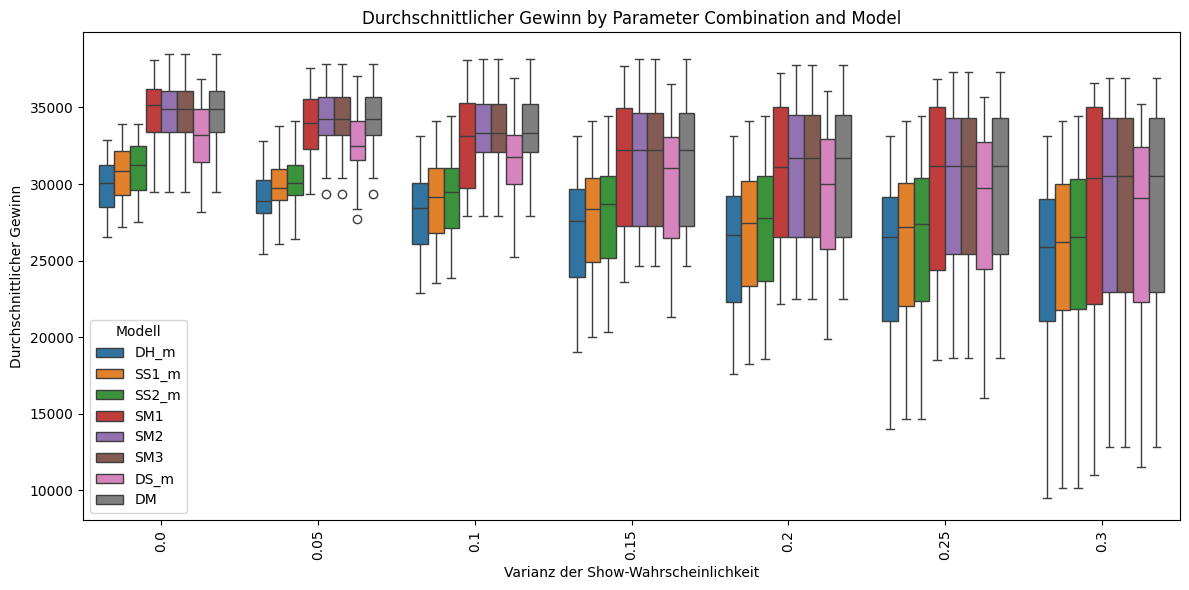

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

df_results_storage_show_rate = df_results_storage[(df_results_storage['arrival_variance']==0) & (df_results_storage['cancellation_variance'] == 0)]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'model']).mean()
# Create the boxplot
sns.boxplot(x='show_variance', y='Total Revenue', hue='Modell',data=df_results_storage_show_rate)

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)

# Set plot title and labels
plt.title('Durchschnittlicher Gewinn by Parameter Combination and Model')
plt.xlabel('Varianz der Show-Wahrscheinlichkeit')
plt.ylabel('Durchschnittlicher Gewinn')
plt.legend(title='Modell')

# Show the plot
plt.tight_layout()
plt.show()

In [103]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cm_show_revenue.pdf')
# Display the plot
p

In [104]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cm_show_revenue_box.pdf')
# Display the plot
p

#### Denied Boardings

In [105]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cm_show_db.pdf')
# Display the plot
p

In [106]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cm_show_db_box.pdf')
# Display the plot
p

#### Unused Inventory

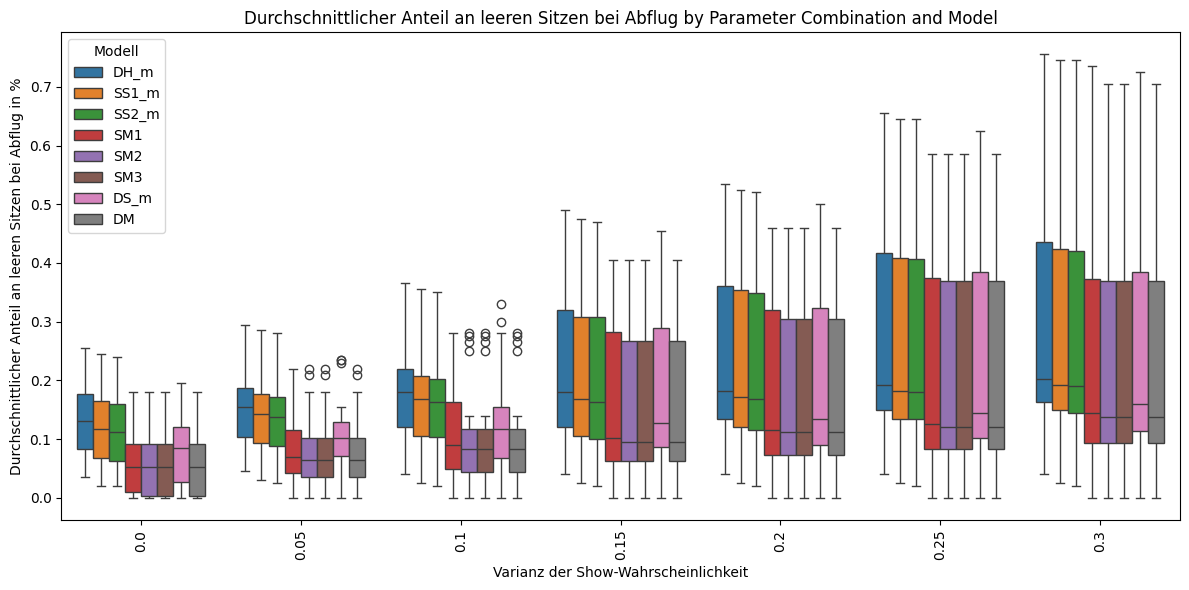

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

df_results_storage_show_rate = df_results_storage[(df_results_storage['arrival_variance']==0) & (df_results_storage['cancellation_variance'] == 0)]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'model']).mean()
# Create the boxplot
sns.boxplot(x='show_variance', y='Unused Inventory', hue='Modell',data=df_results_storage_show_rate)

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)
#plt.ylim(4000, 32500)

# Set plot title and labels
plt.title('Durchschnittlicher Anteil an leeren Sitzen bei Abflug by Parameter Combination and Model')
plt.xlabel('Varianz der Show-Wahrscheinlichkeit')
plt.ylabel('Durchschnittlicher Anteil an leeren Sitzen bei Abflug in %')
plt.legend(title='Modell')

# Show the plot
plt.tight_layout()
plt.show()

In [108]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cm_show_inventory.pdf')
# Display the plot
p

In [109]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['show_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='show_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Show-Wahrscheinlichkeit') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cm_show_inventory_box.pdf')
# Display the plot
p

### Arrival Rate

#### Total Revenue

In [110]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cm_arrival_revenue.pdf')
# Display the plot
p

In [111]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cm_arrival_revenue_box.pdf')
# Display the plot
p

#### Denied Boardings

In [112]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cm_arrival_db.pdf')
# Display the plot
p

In [113]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cm_arrival_db_box.pdf')
# Display the plot
p

#### Unused Inventory

In [114]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
].groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
#ggsave(p, filename='cm_arrival_inventory.pdf')
p

In [115]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['show_variance'] == 0) &
    (df_results_storage['cancellation_variance'] == 0)
]#.groupby(['arrival_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='arrival_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Buchungsanfragen') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
# Display the plot
#ggsave(p, filename='cm_arrival_inventory_box.pdf')
p

### Cancellation Rate

#### Total Revenue

In [116]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['show_variance'] == 0)
].groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cm_cancellation_revenue.pdf')
# Display the plot
p

In [117]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['show_variance'] == 0)
]#.groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Total Revenue', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Gewinn') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cm_cancellation_revenue_box.pdf')
# Display the plot
p

#### Denied Boardings

In [118]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['show_variance'] == 0)
].groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cm_cancellation_db.pdf')
# Display the plot
p

In [119]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['show_variance'] == 0)
]#.groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Denied boardings', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Anzahl Denied Boardings') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cm_cancellation_db_box.pdf')
# Display the plot
p

#### Unused Inventory

In [120]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['show_variance'] == 0)
].groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_point(size = 3) + \
    geom_line() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cm_cancellation_inventory.pdf')
# Display the plot
p

In [121]:
from lets_plot import *
LetsPlot.setup_html()

# Group and filter the data as before

df_results_storage_show_rate = df_results_storage[
    (df_results_storage['arrival_variance'] == 0) &
    (df_results_storage['show_variance'] == 0)
]#.groupby(['cancellation_variance', 'fare_class_probs_1', 'fare_class_probs_2', 'Modell']).mean().reset_index()

# Create a point plot with Lets-Plot
p = ggplot(df_results_storage_show_rate, aes(x='cancellation_variance', y='Unused Inventory', color='Modell', shape='Modell')) + \
    geom_boxplot() + \
    scale_color_brewer(type='qual', palette='Set1') + \
    xlab('Varianz der Ankunftsrate von Cancellations') + \
    ylab('Durchschnittl. Anzahl leerer Sitze in %') + \
    theme(axis_text_x=element_text(angle=90, hjust=1))
#ggsave(p, filename='cm_cancellation_inventory_box.pdf')
# Display the plot
p